# Using time series analysis for sales and demand forecasting



## **Business context**



The Nielsen BookScan service is the world’s largest continuous book sales tracking service in the world, operating in the UK, Ireland, Australia, New Zealand, India, South Africa, Italy, Spain, Mexico, Brazil, Poland, and Colombia. Nielsen BookScan collects transactional data at the point of sale, directly from tills and dispatch systems of all major book retailers. This ensures detailed and highly accurate sales information on which books are selling and at what price, giving clients the most up-to-date and relevant data. The Nielsen BookScan Total Consumer Market (TCM) data covers approximately 90% of all retail print book purchases in the UK. The remaining sites are specialised, such as gift shops, specialist booksellers, and tourist information centres.


Nielsen BookScan can be used to:
Monitor titles and authors against the competition and overall market.
Analyse pricing and discounting by format or category.
Gauge the success of marketing campaigns and promotions.
See which categories are growing and declining.
Learn what works in your market and how that might differ from other countries.

Nielsen BookScan sales data can be analysed by various criteria, including category, publisher, and format,
allowing users to see which genres are selling in which format. Users can track market trends to see which titles are driving the results, and patterns can easily be interpreted. In addition, the actual selling price is included. This inclusion makes it easier to identify trends for the level of discounting (e.g. by title, author, genre, format, region, and publisher) when analysing book sales.

## **Project Aim**

This project aims to help develop a data-driven service for small to medium-sized independent publishers, helping them make informed decisions about new publications based on historical sales data. By analysing sales trends and forecasting demand, the service will enable publishers to optimise stock control, reduce financial risks, and identify books with strong long-term potential. In particular, the project focuses on detecting seasonal sales patterns and key market influences that impact a book’s economic lifespan, allowing for better investment decisions and improved procurement strategies.

 The project will explore various time series forecasting techniques, including Auto ARIMA, XGBoost, and LSTM models, to predict future sales with accuracy. Additionally, hybrid modeling approaches will be tested to enhance predictive performance. By leveraging these insights, the project will provide a PoC for the forecasting of sales, enabling publishers to optimise reordering, restocking, and reprinting decisions, ultimately improving inventory management and ensuring better financial returns.




# Install Libraries

In [ ]:
!pip install openpyxl==3.1.2 -q
!pip install plotly -q
!pip install pmdarima -q
!pip install scikit-learn==1.1.3 -q
!pip install sktime==0.28.0 -q
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 11.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.1/130.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.3 MB/s eta 0:00:00


# Import Libraries

In [ ]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import statsmodels.graphics.api as smgraphics
import tensorflow as tf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Sequential
import keras_tuner as kt
from sktime.forecasting.compose import TransformedTargetForecaster, make_reduction
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from xgboost import XGBRegressor

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

warnings.filterwarnings("ignore", category=FutureWarning)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Mounted at /content/drive


# Helper Functions

Some functions for use in initial Exploratory Data Analysis (EDA) and throughout the notebook.

In [ ]:
def resample_sales(df, period="W"):
    """Resample sales data to a specified period, filling missing values.

    This function resamples the input DataFrame to the given time period,
    filling missing values with zero for sales volume and maintaining
    information across other fields using forward and backward filling.

    Args:
        df (pd.DataFrame): The input sales data DataFrame.
        period (str, optional): The resampling period (e.g., 'W' for weekly).
            Defaults to "W".

    Returns:
        pd.DataFrame: The resampled sales data DataFrame.
    """
    df = df.set_index("End Date")
    df = df.groupby("ISBN").resample(period).agg(
        {
            "Volume": "sum",
            "Title": "first",
            "Author": "first",
            "Interval": "first",
            "Value": "sum",
            "ASP": "first",
            "RRP": "first",
            "Binding": "first",
            "Imprint": "first",
            "Publisher Group": "first",
            "Product Class": "first",
        }
    )
    df = df.reset_index()

    # Forward and backward fill to maintain information
    column_list = [
        "Title",
        "Author",
        "Interval",
        "ASP",
        "RRP",
        "Binding",
        "Imprint",
        "Publisher Group",
        "Product Class",
    ]
    df[column_list] = df[column_list].ffill().bfill()
    df["Volume"] = df["Volume"].fillna(0)
    df = df.reset_index(drop=True)

    return df

In [ ]:
def interactive_plot(df, sheet):
    """Creates an interactive plot of sales volume over time.

    Args:
        df (pd.DataFrame): The input sales data DataFrame.
        sheet (str): The name of the sheet the data is from.
    """
    fig = px.line(
        df,
        x="End Date",
        y="Volume",
        color="Title",
        title=f"Sales Volume for {sheet}",
    )
    fig.update_layout(legend_title_text="Title")
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="left",
                buttons=list(
                    [
                        dict(
                            args=["visible", "legendonly"],
                            label="Deselect All",
                            method="restyle",
                        ),
                        dict(
                            args=["visible", True],
                            label="Select All",
                            method="restyle",
                        ),
                    ]
                ),
                pad={"r": 10, "t": 10},
                showactive=False,
                x=1,
                xanchor="right",
                y=1.1,
                yanchor="top",
            ),
        ],
        plot_bgcolor="white",
        paper_bgcolor="white",
        xaxis=dict(linecolor="black"),
        yaxis=dict(linecolor="black"),
        title=dict(text=f"<b>Sales Volume for {sheet}</b>"),
    )

    fig.show()

In [ ]:
def seasonal_decomposition(df, title, period=52, seasonal=101, trend=101):
    """Performs seasonal decomposition and plots the components.

    Args:
        df (pd.DataFrame): Input DataFrame with a 'Volume' column.
        title (str): Title for the plots.
        period (int, optional): Seasonal period. Defaults to 52.
        seasonal (int, optional): Seasonal smoother window size. Defaults to 101.
        trend (int, optional): Trend smoother window size. Defaults to 101.
    """
    stl = STL(df["Volume"], period=period, seasonal=seasonal, trend=trend)
    result = stl.fit()
    seasonal_component = result.seasonal
    trend_component = result.trend
    residuals = result.resid
    model = seasonal_component + trend_component

    # Create plots
    fig, axes = plt.subplots(3, 1, figsize=(12, 6))
    axes[0].plot(df["Volume"], label="Original Data")
    axes[0].plot(model, label="Model (Seasonal + Trend)")
    axes[0].set_title("Original Data and Model")
    axes[0].legend()
    axes[1].plot(seasonal_component, label="Seasonal Component")
    axes[1].set_title("Seasonal Component")
    axes[2].plot(trend_component, label="Trend Component")
    axes[2].set_title("Trend Component")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    axes[0].scatter(df.index, residuals, label="Residuals", s=5)
    axes[0].set_title("Residuals")
    sm.qqplot(residuals, line="s", ax=axes[1])
    axes[1].set_title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

In [ ]:
def ACF_PACF(df, title):
    """Plots ACF and PACF for a time series in a dataframe.

    Args:
        df (pd.DataFrame): The input DataFrame with a 'Volume' column.
        title (str): Title for the plots.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # Plot ACF and PACF with lag of 120 (approximately 2 years)
    smgraphics.tsa.plot_acf(df["Volume"], lags=120, ax=axes[0])
    smgraphics.tsa.plot_pacf(df["Volume"], lags=120, ax=axes[1])

    plt.suptitle(
        f"Autocorrelation and Partial Autocorrelation Functions for {title}",
        fontsize=16,
    )
    plt.tight_layout()
    plt.show()

In [ ]:
def test_train_split(df, n_test):
    """Generates train and test data sets.

    Args:
        df (pd.DataFrame): The input DataFrame.
        n_test (int): The number of data points for the test set.

    Returns:
        tuple: A tuple containing the train and test DataFrames.
    """
    train = df.iloc[:-n_test]
    test = df.iloc[-n_test:]
    return train, test

In [ ]:
def plot_and_evaluate(train, test, predictions, title, freq="W", benchmark = None, benchmark_lab = None):
    """
    Plots predictions along with train and test data and outputs evaluation metrics.
    Args:
        train (pd.DataFrame): The training data.
        test (pd.DataFrame): The test data.
        predictions (pd.Series): The predicted values.
        title (str): The title of the plot.
        freq (str, optional): The resampling period (e.g., 'W' for weekly).
        Defaults to "W".
        benchmark (pd.Series, optional): Optionak benchmark data for comparison.
        benchmark_lab (str, optional): Label for the benchmark data.
    """

    fig, axes = plt.subplots(2, 1, figsize=(12, 7))

    # Plot data
    axes[0].plot(train.index, train, label="Train", color="b")
    axes[0].plot(test.index, predictions, label="Prediction", color="green")
    axes[0].plot(test.index, test, label="Test", color="orange")
    if benchmark is not None:
        axes[0].plot(test.index, benchmark, label=benchmark_lab, color="red", linestyle ="--" )

    axes[0].set_title(title)
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Series")
    axes[0].legend()

    # Plot data (Expanded)
    axes[1].plot(train.index, train, label="Train", color="b")
    axes[1].plot(test.index, predictions, label="Prediction", color="green")
    axes[1].plot(test.index, test, label="Test", color="orange")
    if benchmark is not None:
        axes[1].plot(test.index, benchmark, label=benchmark_lab, color="red", linestyle ="--" )

    axes[1].set_title(f"{title} (Expanded)")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Series")
    axes[1].legend()

    # Set x-axis limits based on frequency
    if freq == "W":
        axes[1].set_xlim(
            train.index[-64], train.index[-64] + pd.DateOffset(weeks=96)
        )
    elif freq == "M":
        axes[1].set_xlim(
            train.index[-24], train.index[-24] + pd.DateOffset(months=32)
        )

    # Calculate metrics
    mae = mean_absolute_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)

    plt.tight_layout()
    plt.show()

    # Create and display evaluation DataFrame
    evaluation = pd.DataFrame({"Test": [mape, mae]}, index=["MAPE", "MAE"])
    display(evaluation)
    return evaluation

# Download Data

Download the ISBN List and UK weekly trended sales timeline into a dictionary of dataframes



In [ ]:
# ISBN List .xlsx url
ISBN_loc = 'http://drive.google.com/uc?export=download&id=1P7HwOIrJuk1n9JCW81xiNBSP7LUfaW57'
# Read ISBN sheets into a dictionary of dataFrames
ISBN_sheets = pd.read_excel(ISBN_loc, sheet_name=None)

In [ ]:
# UK weekly trended sales timeline  .xlsx url
sales_loc = 'http://drive.google.com/uc?export=download&id=16Hw57l_-Bc2OSHefYg6Sg9UpUuAiezJt'
# Read all sheets of the Excel file into a dictionary of dataFrames
sales_sheets = pd.read_excel(sales_loc, sheet_name=None)

# Initial Data Exploration

In [ ]:
# An inital look at the datasets
for sheet, df in sales_sheets.items():
    print(f"Sheet: {sheet}\n")
    display(df.head())
    print(df.shape)
    print("\n")

Sheet: F Adult Fiction



ISBN            Title         Author  Interval   End Date  Volume  \
0  9780002261821  One For My Baby  Parsons, Tony    200513 2005-04-02       1   
1  9780002261821  One For My Baby  Parsons, Tony    200503 2005-01-22       1   
2  9780002261821  One For My Baby  Parsons, Tony    200422 2004-05-29       1   
3  9780002261821  One For My Baby  Parsons, Tony    200415 2004-04-10       2   
4  9780002261821  One For My Baby  Parsons, Tony    200404 2004-01-24       2   

   Value    ASP    RRP   Binding                   Imprint    Publisher Group  \
0  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
1  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
2  11.19  11.19  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
3  27.18  13.59  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
4  22.48  11.24  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   

                     Product Class  
0  F1.1 General & Literary Fiction  
1  F1.1 General & Literary Fiction  
2  F1.1 General & Literary Fiction  
3  F1.1 General & Literary Fiction  
4  F1.1 General & Literary Fiction

(73767, 13)


Sheet: S Adult Non-Fiction Specialist



ISBN                    Title  \
0  9780003224764  Psychology for AS-level   
1  9780003224764  Psychology for AS-level   
2  9780003224764  Psychology for AS-level   
3  9780003224764  Psychology for AS-level   
4  9780003224764  Psychology for AS-level   

                                          Author  Interval   End Date  Volume  \
0  Cardwell, Mike & Clark, Liz & Meldrum, Claire    200917 2009-04-25       1   
1  Cardwell, Mike & Clark, Liz & Meldrum, Claire    200840 2008-10-04       1   
2  Cardwell, Mike & Clark, Liz & Meldrum, Claire    200838 2008-09-20       1   
3  Cardwell, Mike & Clark, Liz & Meldrum, Claire    200623 2006-06-10       1   
4  Cardwell, Mike & Clark, Liz & Meldrum, Claire    200603 2006-01-21      -1   

   Value    ASP    RRP    Binding              Imprint    Publisher Group  \
0   4.96   4.96  12.99  Paperback  Collins Educational  HarperCollins Grp   
1   0.99   0.99  12.99  Paperback  Collins Educational  HarperCollins Grp   
2   0.99   0.99  12.99  Paperback  Collins Educational  HarperCollins Grp   
3   2.00   2.00  12.99  Paperback  Collins Educational  HarperCollins Grp   
4 -12.99  12.99  12.99  Paperback  Collins Educational  HarperCollins Grp   

                                Product Class  
0  S2.2T Psychology: Textbooks & Study Guides  
1  S2.2T Psychology: Textbooks & Study Guides  
2  S2.2T Psychology: Textbooks & Study Guides  
3  S2.2T Psychology: Textbooks & Study Guides  
4  S2.2T Psychology: Textbooks & Study Guides

(32827, 13)


Sheet: T Adult Non-Fiction Trade



ISBN              Title        Author  Interval   End Date  \
0  9780002572040  Dog Listener, The  Fennell, Jan    200919 2009-05-09   
1  9780002572040  Dog Listener, The  Fennell, Jan    200918 2009-05-02   
2  9780002572040  Dog Listener, The  Fennell, Jan    200917 2009-04-25   
3  9780002572040  Dog Listener, The  Fennell, Jan    200916 2009-04-18   
4  9780002572040  Dog Listener, The  Fennell, Jan    200914 2009-04-04   

   Volume  Value     ASP    RRP   Binding                   Imprint  \
0       1   2.38  2.3800  14.99  Hardback  HarperCollins Publishers   
1       3   8.42  2.8067  14.99  Hardback  HarperCollins Publishers   
2       6   7.66  1.2767  14.99  Hardback  HarperCollins Publishers   
3       3   3.28  1.0933  14.99  Hardback  HarperCollins Publishers   
4       2   2.48  1.2400  14.99  Hardback  HarperCollins Publishers   

     Publisher Group        Product Class  
0  HarperCollins Grp  T11.4 Pets & Equine  
1  HarperCollins Grp  T11.4 Pets & Equine  
2  HarperCollins Grp  T11.4 Pets & Equine  
3  HarperCollins Grp  T11.4 Pets & Equine  
4  HarperCollins Grp  T11.4 Pets & Equine

(65344, 13)


Sheet: Y Children's, YA & Educational



ISBN                Title      Author  Interval   End Date  \
0  9780001713031  Cat in the Hat, The  Seuss, Dr.    201433 2014-08-16   
1  9780001713031  Cat in the Hat, The  Seuss, Dr.    200742 2007-10-20   
2  9780001713031  Cat in the Hat, The  Seuss, Dr.    200741 2007-10-13   
3  9780001713031  Cat in the Hat, The  Seuss, Dr.    200738 2007-09-22   
4  9780001713031  Cat in the Hat, The  Seuss, Dr.    200737 2007-09-15   

   Volume  Value   ASP   RRP    Binding  Imprint    Publisher Group  \
0       5  24.95  4.99  4.99  Paperback  Collins  HarperCollins Grp   
1       1   3.99  3.99  4.99  Paperback  Collins  HarperCollins Grp   
2       3  14.97  4.99  4.99  Paperback  Collins  HarperCollins Grp   
3       4  18.96  4.74  4.99  Paperback  Collins  HarperCollins Grp   
4       2   7.98  3.99  4.99  Paperback  Collins  HarperCollins Grp   

                    Product Class  
0  Y4.2 Reference & Home Learning  
1  Y4.2 Reference & Home Learning  
2  Y4.2 Reference & Home Learning  
3  Y4.2 Reference & Home Learning  
4  Y4.2 Reference & Home Learning

(55286, 13)




## Clean Data and Pre-process

In [ ]:
# Convert datatypes
for sheet, df in sales_sheets.items():
    # For all ISBN columns convert to string
    df['ISBN'] = df['ISBN'].astype(str)
    # Convert End Date to datetime format
    df['End Date'] = pd.to_datetime(df['End Date'])

for sheet, df in ISBN_sheets.items():
    # For all ISBN columns convert to string
    df['ISBN'] = df['ISBN'].astype(str)
    # Convert Publication Date to datetime format
    df['Publication Date'] = pd.to_datetime(df['Publication Date'])


In [ ]:
# Resample data to weekly, filling in missing weeks with zero for sales volume
resampled_sales_sheets = {}

for sheet, df in sales_sheets.items():
    resampled_sales_sheets[sheet] = resample_sales(df,'W')

In [ ]:
# Filter out the ISBNs in all_sheets where sales data exists beyond 2024-07-01.
sales_sheets_filtered = {}
for sheet, df in resampled_sales_sheets.items():
     sales_sheets_filtered[sheet] =  df[df['End Date'] > pd.to_datetime('2024-07-01')]

Filter out books with sales data beyond 2024-07-01

In [ ]:
# Create a list of the ISBNs for these books where sales data exists beyond 2024-07-01.
ISBN_recent =[]
for sheet, df in sales_sheets_filtered.items():
    ISBN_recent.extend(df['ISBN'].unique())
# Ensure there are no more duplicates
ISBN_recent = list(set(ISBN_recent))

In [ ]:
# Create a filtered list from the ISBN list of books where sales data exists beyond 2024-07-01
filtered_ISBN_sheets = {}

for sheet, df in ISBN_sheets.items():
    # Filter the DataFrame based on ISBNs with sales data beyond 2024-07-01
    filtered_ISBN_sheets[sheet] = df[df['ISBN'].isin(ISBN_recent)]

In [ ]:
# Output the book titles and ISBNs, in their categories, for these books where
# sales data exists beyond 2024-07-01
recent_books_df = pd.DataFrame(columns=['Title', 'ISBN', 'Category'])
for sheet, df in filtered_ISBN_sheets.items():
    print(f"Sheet: {sheet}\n")
    for index, row in df.iterrows():
        title = row['Title']
        isbn = row['ISBN']
        category = sheet
        recent_books_df = pd.concat([recent_books_df,
                                     pd.DataFrame([{'Title': title,
                                                    'ISBN': isbn,
                                                    'Category': category}])],
                                    ignore_index=True)
        print(f"- {title} (ISBN: {isbn})")

    print("\n")

Sheet: F - Adult Fiction

- White Teeth (ISBN: 9780140276336)
- Man and Boy (ISBN: 9780006512134)
- Marrying The Mistress:an irresistible and gripping romantic drama from one of Britain’s best loved authors, Joanna Trolloper (ISBN: 9780552998727)
- Chocolat:(Chocolat 1) (ISBN: 9780552998482)
- Blackberry Wine:from Joanne Harris, the bestselling author of Chocolat, comes a tantalising, sensuous and magical novel which takes us back to the charming French village of Lansquenet (ISBN: 9780552998000)
- Captain Corelli's Mandolin:AS SEEN ON BBC BETWEEN THE COVERS (ISBN: 9780749397548)
- English Passengers (ISBN: 9780140285215)
- Fortune's Rocks (ISBN: 9780349112763)
- Lord of the Rings,The (ISBN: 9780261103252)
- Glass Palace,The (ISBN: 9780006514091)
- Journey (ISBN: 9780552145060)
- Best a Man Can Get,The (ISBN: 9780552998444)
- Emotionally Weird (ISBN: 9780552997348)
- Sky is Falling,The (ISBN: 9780007101887)
- Alchemist,The (ISBN: 9780722532935)
- One-hit Wonder (ISBN: 9780140295962)
- 

In [ ]:
# Filter the original sales sheets down to these recent titles
sales_sheets_recent = {}

for sheet, df in resampled_sales_sheets.items():
    # Filter the DataFrame based on 'Title' values in recent_books
    filtered_df = df[df['ISBN'].isin(ISBN_recent)]

    # Store the filtered DataFrame in the dictionary
    sales_sheets_recent[sheet] = filtered_df

In [ ]:
# Plot the sales volumes for these books with sales beyond 2024-07-01
# Plotly used as it allows nice interactive features to explore the data

for sheet, df in sales_sheets_recent.items():
    interactive_plot(df, sheet)

General Trends Observed in the Data:

*   **Cessation of Sales During Lockdowns:** Sales dropped to zero during the three UK national lockdowns in 2020–2021.

*  **Long-Term Sales Decline:** Most titles exhibit a clear trend of declining sales over the first 12 years, followed by broadly stable sales for the next 12–24 years. This decline may be attributed to the emergence of competing forms of media, such as eBooks and audiobooks.

*   **Exceptions Among Certain Categories:** Some books, particularly in the Children's, Young Adult, and Educational categories, do not follow this pattern of decline. Instead, their sales remain relatively steady over the 24-year period. Notable examples include picture books like _'The Very Hungry Caterpillar'_ and _'We're Going on a Bear Hunt'_. This stability may reflect the nature of these books, their target audience (children), and the limited competition from other media formats.

*   **Seasonal Sales Patterns:** Most books display seasonal sales trends, with pronounced spikes in December likely due to Christmas. Many titles also show a secondary spike in summer. For example, _'Jacqueline Wilson Double Decker'_ and _'Captain Corelli’s Mandolin'_ are good examples of this dual-seasonal trend. In contrast, revision guides follow a distinct seasonal pattern, with sales strongly influenced by the academic exam calendar.

*   **Wide Variation in Sales Volumes**: There is significant variation in the number of copies sold, with some titles achieving high sales figures while others only sell in very small numbers. This variability makes it challenging to identify consistent trends across all books.


## Subset the data for _'The Alchemist'_ and _'The Very Hungry Caterpillar'_

Sales data for _'The Alchemist'_ and _'The Very Hungry Caterpillar'_ show interesting data and trends, so they will be investigated further. Firstly, they will be subset from the primary dataset and filtered to only to include the last 12 years' data, where the significant nonlinear trends in sales for many titles are not strongly seen, unlike the previous 12 years.

In [ ]:
# Set ISBN for 'The Alchemist'
alchemist_ISBN = '9780722532935'
# Set ISBN for 'The Very Hungry Caterpillar'
tvhc_ISBN = '9780241003008'

In [ ]:
# Create new dataframes for The Alchemist
alchemist_df = sales_sheets_recent["F Adult Fiction"][sales_sheets_recent["F Adult Fiction"]['ISBN'] == alchemist_ISBN]
# Create new dataframes for The Very Hungry Caterpillar
tvhc_df = sales_sheets_recent["Y Children's, YA & Educational"][sales_sheets_recent["Y Children's, YA & Educational"]['ISBN'] == tvhc_ISBN]

In [ ]:
# Reduce datasets to entries after 2012-01-01
alchemist_df = alchemist_df[alchemist_df['End Date'] > pd.to_datetime('2012-01-01')]
tvhc_df = tvhc_df[tvhc_df['End Date'] > pd.to_datetime('2012-01-01')]

In [ ]:
# Set 'End Date' as the time index
tvhc_df.set_index('End Date', inplace=True)
alchemist_df.set_index('End Date', inplace=True)

### EDA _'The Alchemist'_

In [ ]:
# Plot out weekly sales volumes for The Alchemist
plot = px.line(alchemist_df, x=alchemist_df.index, y='Volume', title='Weekly Sales Volumes for The Alchemist')
plot.show()

In [ ]:
# The Alchemist sales - summary stats
alchemist_df['Volume'].describe()

count     655.000000
mean      528.102290
std       227.965588
min         0.000000
25%       415.500000
50%       508.000000
75%       606.000000
max      2201.000000
Name: Volume, dtype: float64

### EDA _'The Very Hungry Caterpillar'_

In [ ]:
# Plot out weekly sales volumes for The Very Hungry Caterpillar
plot = px.line(tvhc_df, x=tvhc_df.index, y='Volume', title='Weekly Sales Volumes for The Very Hungry Caterpillar')
plot.show()

In [ ]:
# The Alchemist sales - summary stats
tvhc_df['Volume'].describe()

count     655.000000
mean     1348.906870
std       710.692525
min         0.000000
25%       723.000000
50%      1324.000000
75%      1758.500000
max      3905.000000
Name: Volume, dtype: float64

Both of these books have strong seasonal trends, with significant increases in sales volumes in December. Seasonal changes are much more pronounced above the variance of the dataset for _'The Alchemist'_ unlike _'The Very Hungry Caterpillar'_, where the seasonal variance is closer in magnitude to the variance, making it harder to see the trends visually.

During these 12 years, the trend component for _'The Alchemist'_ appears relatively constant. _'The Very Hungry Caterpillar'_ may have a slightly increasing trend, but it is challenging to gauge visually as this title's volume trend appears to have a large amount of variance.

# Classical Techniques

Here the  Seasonal-Trend Decomposition Procedure Based on Loess (STL) is used within a bespoke function [```seasonal_decomposition```](#scrollTo=jajdNk_K5sr7&line=6&uniqifier=1) to analyse the sales data for the _'The Alchemist'_ and _'The Very Hungry Caterpillar'_

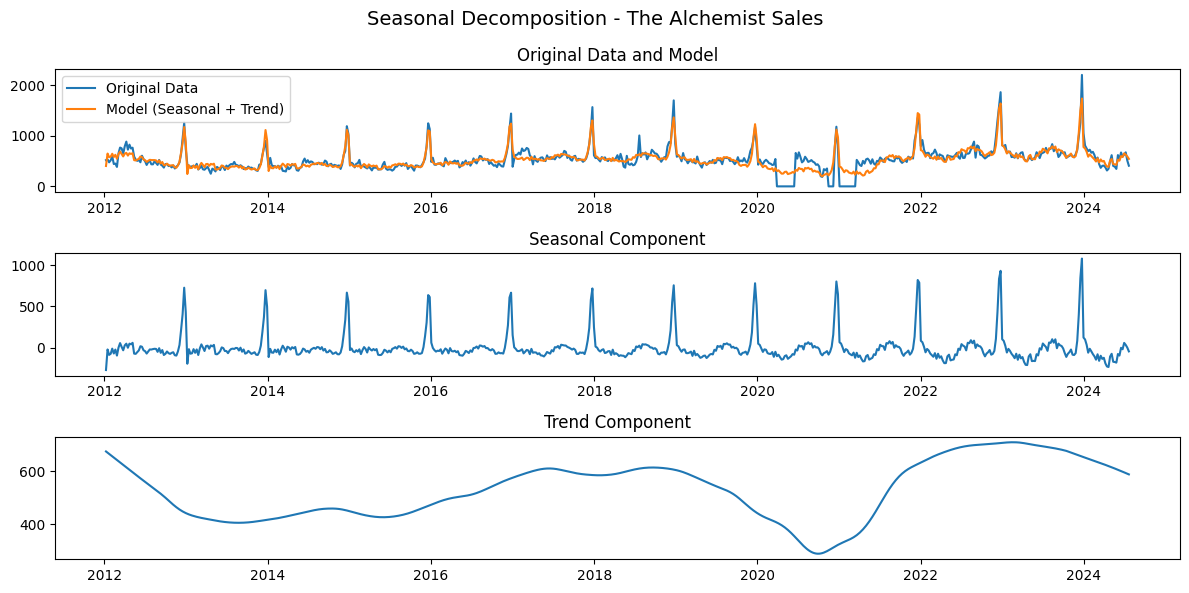

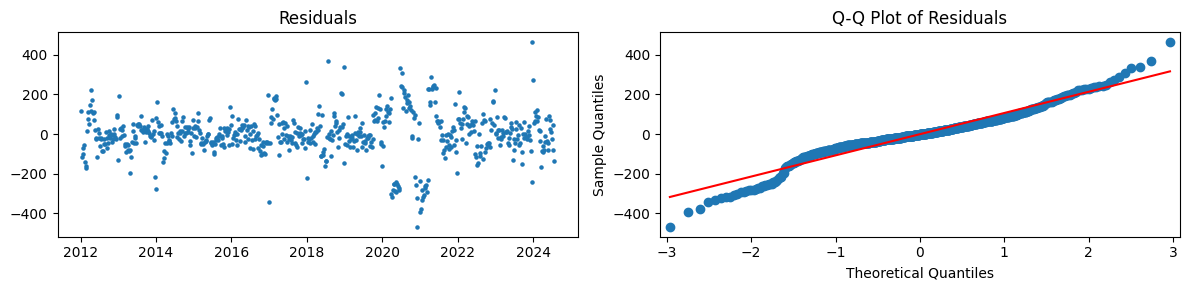

In [ ]:
# Seasonal decompostion of The Alchemist.
# Seasonal and trend parameters adjusted to allow the residuals to appear close to white noise

seasonal_decomposition(alchemist_df,
                       'Seasonal Decomposition - The Alchemist Sales',
                       period = 52,
                       seasonal = 21,
                       trend = 81)

The decomposition of the time series into seasonal and trend components is very helpful in identifying further patterns in the The Achemist's sales data.

**Seasonal** With the extraction of the seasonal data and effectively smoothing the data it can be clearly seen that there are two seasonal trends in sales of_'The Alchemist'_. A sharp annual spike in sales for December and a broader and lower increase in sales during the summer period.

**Trend** Overall there is not a large change in sales from the start fo the 12 year period to the end but there are notable drops and variations in sales. For example during the UK lockdown periods.

**Residuals** Although the STL method is useful in extracting the seasonal and trend components, it can be seen that it hasn't fully explained the data. The residuals still contain some structure and are not quite normal in their distribution.

The decomposition shows reasonably constant variance across the period for the seasonal component, suggesting an additive decomposition model is suitable for modelling.

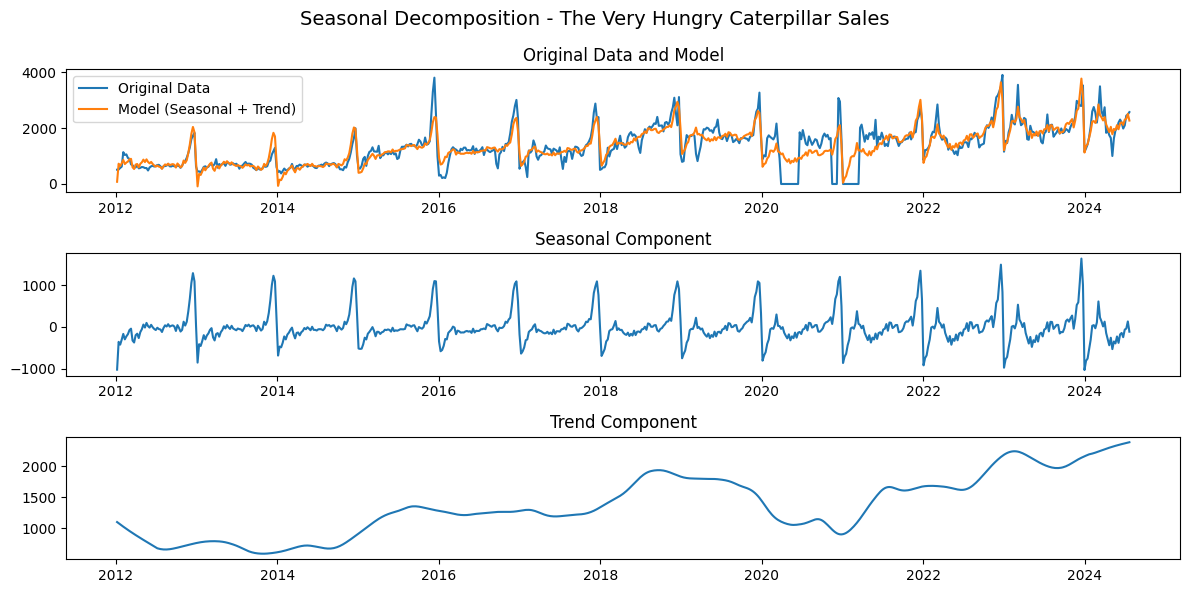

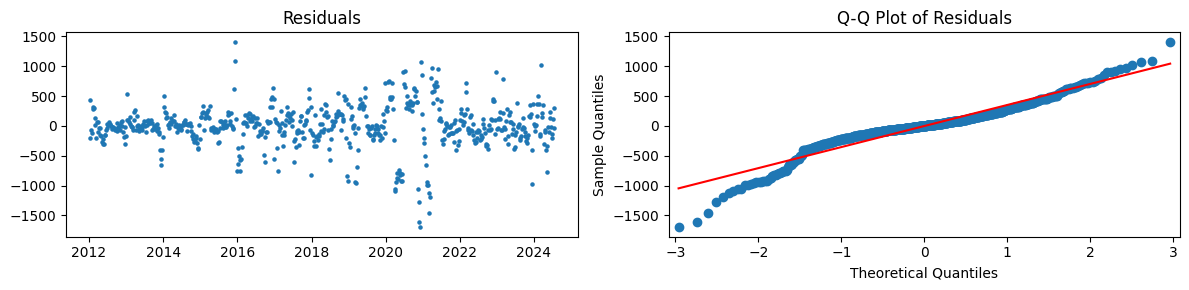

In [ ]:
# Seasonal decompostion of The Very Hungry Caterpillar.
# Seasonal and trend adjusted to allow residuals to appear close to white noise
seasonal_decomposition(tvhc_df,
                       'Seasonal Decomposition - The Very Hungry Caterpillar Sales',
                       period = 52,
                       seasonal = 181,
                       trend =53)

The decomposition of the time series into seasonal and trend components is very helpful in identifying further patterns in  _'The Very Hungry Caterpillar'_'_'s sales data.

**Seasonal** With the extraction of the seasonal data and effectively smoothing the data, it can be seen that there is a very strong 'spike and dip' seasonal pattern, with sales volumes peaking in December and following this sales drop significantly below the running mean, taking some time to recover

**Trend** Overall, there has been a steady increase in sales over the 12 years, with sales almost doubling from 2012 to 2024. It should be noted that there is also a large amount of variance across this period.

**Residuals** Although the STL method helps extract the seasonal and trend components, it hasn't fully explained the data. The residuals still contain some seasonal structure and are not quite normal in their distribution.

The decomposition shows reasonably constant variance across the period for the seasonal component, suggesting an additive decomposition model is suitable for modelling.

### Autocorrelation (ACF) and Partial Autocorrelation Functions (PACF)

Plot of ACF and PACF using the [```ACF_PACF```](#scrollTo=znqtLaRy_eyu&line=5&uniqifier=1) bespoke helper function above.

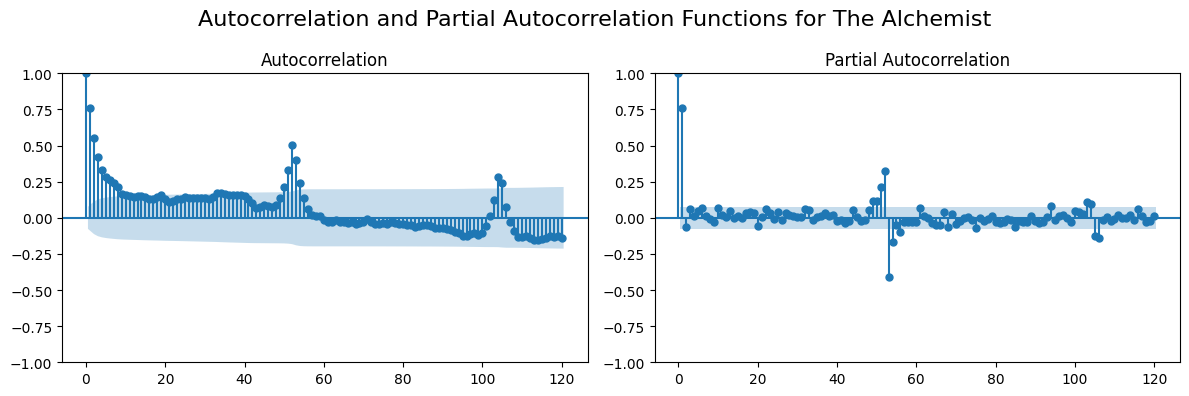

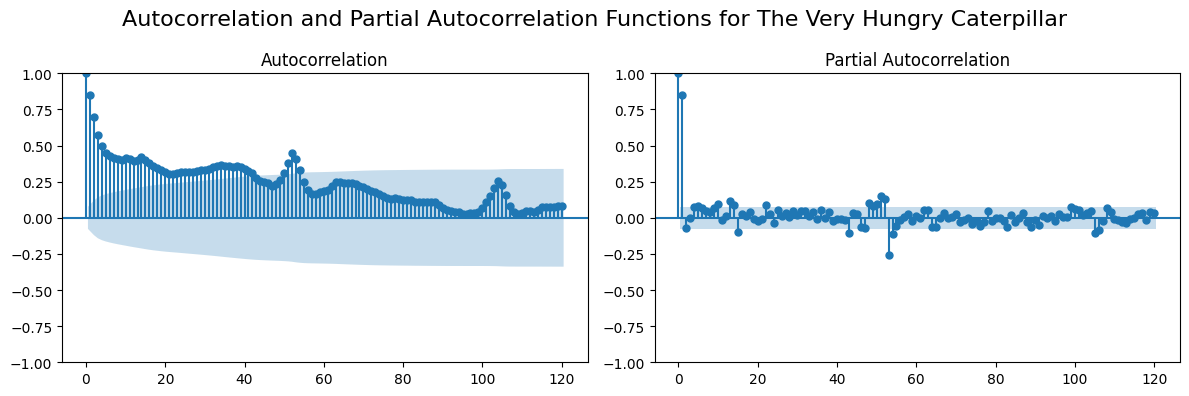

In [ ]:
# Plot autocorrelation and partial autocorrelation functions for the two books
ACF_PACF(alchemist_df, 'The Alchemist')
ACF_PACF(tvhc_df, 'The Very Hungry Caterpillar')


**_The Alchemist_**

For the ACF there is a decay/tapering over approx 10 lags before they fall withing the 95% confidence interval suggesting that the series has a slight trend or persistence over time.
The ACF has lags which appear out the confidence interval at repeating intervals of 52 lags as a result of the annual trend observed.

The PACF has a sharp cutoff after Lag 1. This large spike at lag 1 suggest that the series may follow an autoregressive (AR) process. Beyond these lags, most points fall within the confidence bounds, indicating little additional contribution. As the the PACF cuts off abruptly, it suggests an AR process rather than a moving average (MA) process. Possibly AR(1).


**_The Very Hungry Caterpillar_**

For the ACF there is a very slow decay/tapering and only goes within the over  the 95% confidence interval after ~40 lags suggesting that the series has a a stronger trend than observed for_'The Alchemist'_.
The ACF has peaks in the lags which appear at repeating intervals of 52 lags as a result of the annual trend observed.

The PACF has a sharp Cutoff after Lag 1. This large spike at lag 1 suggests that the series may follow an autoregressive (AR) process. Beyond these lags, most points fall within the confidence bounds, indicating little additional contribution. As the PACF cuts off abruptly, it suggests an AR process rather than a moving average (MA) process. Possibly AR(1).

### Augmented Dickey-Fuller Test (ADF)

In [ ]:
# Testing for stationarity - ADF Test
adf_result = adfuller(tvhc_df['Volume'])
print('p-value. The Very Hungry Caterpillar:', adf_result[1])

adf_result = adfuller(alchemist_df['Volume'])
print('p-value, The Alchemist:', adf_result[1])

p-value. The Very Hungry Caterpillar: 0.029616021527175844
p-value, The Alchemist: 4.139950997174928e-13


The p-value for  _'The Very Hungry Caterpillar'_'_ is much larger than for The Alchemist, and this is consistent with the trends we have observed above when integrating the data. However, with both p values < 0.05, this indicates that for both time series of  _'The Very Hungry Caterpillar'_ and _'The Alchemist'_, we can reject the null hypothesis that states the data is non-stationary at the 95% significance level. They do not contain a unit root.

## Auto ARIMA

### ARIMA Helper Functions

Some functions specific to the seasonal ARIMA analysis.

In [ ]:
def auto_arima_fit(train, test, m=52):
    """
    Undertake auto ARIMA and output predictions, residuals and the best model.
    """
    # Undertake auto ARIMA modelling
    model = auto_arima(
        train,
        X=None,
        start_p=0,
        d=0,
        start_q=0,
        max_p=2,
        max_d=2,
        max_q=2,
        start_P=0,
        D=0,
        start_Q=0,
        max_P=2,
        max_D=2,
        max_Q=2,
        m=m,
        test="adf",
        suppress_warnings=True,
        error_action="trace",
        trace=True,
        stepwise=True,
        with_intercept="auto",
    )
    display(model.summary())
    # Get the residuals
    residuals = model.resid()
    # Use the model to forecast the next time steps.
    predictions = model.predict(
        test.shape[0], return_conf_int=True, alpha=0.05
    )

    return predictions, residuals, model

In [ ]:
def plot_arima_prediction(train, test, model, predictions, title):
    """Plots ARIMA predictions and confidence intervals, residuals, and evaluation metrics."""

    # Plot predictions and confidence intervals
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.plot(train, label="Train")
    ax.plot(test, label="Test")
    ax.plot(model.fittedvalues(), ":", color="red", label="Forecast")
    ax.plot(predictions[0], label="Prediction")
    ax.plot(
        test.index, predictions[1][:, 0], ":", color="grey", label="95% CI Lower"
    )
    ax.plot(
        test.index, predictions[1][:, 1], ":", color="grey", label="95% CI Upper"
    )
    ax.set_title(f"ARIMA modelled time series for {title}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Series")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Plot residuals and Q-Q plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    axes[0].scatter(train.index, model.resid(), label="Residuals", s=5)
    axes[0].set_title("Residuals")
    sm.qqplot(model.resid(), line="s", ax=axes[1])
    axes[1].set_title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

    # Calculate and display evaluation metrics
    data = {
        "Train": [
            mean_absolute_percentage_error(train, model.fittedvalues()) * 100,
            mean_absolute_error(train, model.fittedvalues()),
        ],
        "Test": [
            mean_absolute_percentage_error(test, predictions[0]),
            mean_absolute_error(test, predictions[0]),
        ],
    }
    evaluation = pd.DataFrame(data, index=["MAPE", "MAE"])
    display(evaluation)
    return evaluation

In [ ]:
# Split the data into train and test using the last 32 weeks as a test set.
tvhc_train, tvhc_test = test_train_split(tvhc_df, 32)
alchemist_train, alchemist_test = test_train_split(alchemist_df, 32)

### Auto ARIMA - _'The Alchemist'_

Here, seasonal ARIMA will be fitted using the bespoke function [```auto_arima_fit```](#scrollTo=NSMpbZx3jTHM&line=5&uniqifier=1). Search parameters have been guided using the ACF and PACF above, but also allow some freedom to explore parameters slightly out of those suggested above.

In [ ]:
# Fit the auto ARIMA model with a seasonal component to The Alchemist
alchemist_arima_predictions, alchemist_arima_residuals, alchemist_arima_model = auto_arima_fit(
    alchemist_train['Volume'], alchemist_test['Volume']
    )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=8485.150, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=26.58 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=7988.526, Time=11.13 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=9669.899, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=8110.153, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=7976.778, Time=22.60 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=7942.434, Time=14.74 sec
 ARIMA(0,0,1)(2,0,0)[52] intercept   : AIC=7937.676, Time=56.76 sec
 ARIMA(0,0,1)(2,0,1)[52] intercept   : AIC=inf, Time=51.43 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=62.65 sec
 ARIMA(1,0,1)(2,0,0)[52] intercept   : AIC=7634.377, Time=95.32 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=7678.056, Time=29.92 sec
 ARIMA(1,0,1)(2,0,1)[52] intercept   : AIC=inf, Time=93.83 sec
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=7677.801, Time=22.53 sec
 ARIMA(1,0,0)(2,0,0)[52] int

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  623
Model:             SARIMAX(1, 0, 2)x(2, 0, [], 52)   Log Likelihood               -3806.553
Date:                             Tue, 14 Jan 2025   AIC                           7627.107
Time:                                     20:24:03   BIC                           7658.149
Sample:                                 01-08-2012   HQIC                          7639.170
                                      - 12-10-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.1548      3.221      3.463      0.001       4.842      17.468
ar.L1          0.9243      0.016     57.759      0.000       0.893       0.956
ma.L1         -0.2377      0.033     -7.255      0.000      -0.302      -0.173
ma.L2         -0.1392      0.038     -3.702      0.000      -0.213      -0.066
ar.S.L52       0.4366      0.027     16.217      0.000       0.384       0.489
ar.S.L104      0.2974      0.026     11.228      0.000       0.245       0.349
sigma2       1.12e+04    338.415     33.107      0.000    1.05e+04    1.19e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1298.88
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.00   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

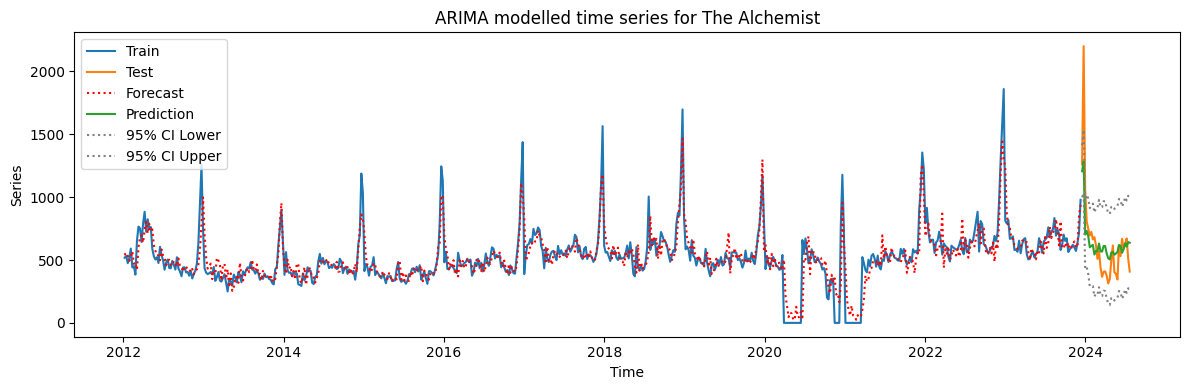

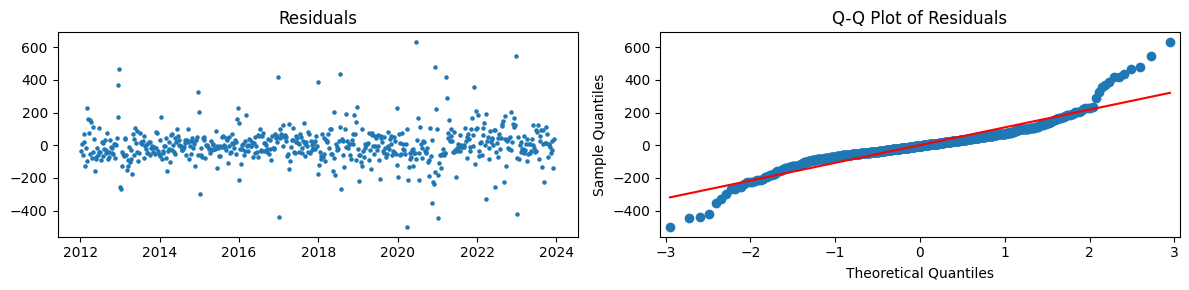

Train        Test
MAPE  2.615693e+18    0.252600
MAE   7.100939e+01  141.980767

In [ ]:
# Plot the predication from the auto ARIMA model for The Alchemist
alchemist_arima_metrics = plot_arima_prediction(alchemist_train['Volume'],
                                                alchemist_test['Volume'],
                                                alchemist_arima_model,
                                                alchemist_arima_predictions,
                                                'The Alchemist')

In [ ]:
# Create dataframe to store metrics
alchemist_metrics_df = pd.DataFrame(alchemist_arima_metrics['Test'])
alchemist_metrics_df.columns = ['ARIMA']

The auto ARIMA for _'The Alchemist'_ favoured an ARIMA(1,0,2)(2,0,0)[52] model with MAPE of 25.3 % and a MAE of 142. The AR(1) is consistent with the ACF and PACF analysis but interestingly an MA(2) component is suggested. It should be noted the AIC is also very close for this model and the ARIMA(1,0,1)(2,0,0)[52] model where the moving average is set to 1 MA(1)

The p-value of 0.92 for the Ljung-Box test indicates no autocorrelation within the residuals. However, the p-value of zero for the Jarque-Bera test indicates that the residuals are not normally distributed. This is also shown by the high Kurtosis (9.98) and Q-Q plot, suggesting a more 'peaked' distribution of the residuals. This non-normal distribution should be remembered if using this model and for any subsequent statistical tests that are utilised.

The predictions for the last 32 weeks are reasonable. However, the magnitude of the seasonal increase in sales at the start of the test set is strongly underestimated compared to the observed values.

### Auto ARIMA - _'The Very Hungry Caterpillar'_

In [ ]:
# Fit the auto ARIMA model with a seasonal component to The Very Hungry Caterpillar
tvhc_arima_predictions, tvhc_arima_residuals, tvhc_arima_model = auto_arima_fit(
    tvhc_train['Volume'], tvhc_test['Volume']
    )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=9915.061, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=9022.083, Time=26.81 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=9391.356, Time=6.42 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=10862.645, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=9112.714, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=73.94 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=52.05 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=9052.711, Time=7.46 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=9001.670, Time=77.76 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=74.43 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=9007.742, Time=66.34 sec
 ARIMA(0,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=40.01 sec
 ARIMA(2,0,0)(2,0,1)[52] intercept   : AIC=9011.617, Time=64.23 sec
 ARIMA(1,0,1)(2,0,1)[52] intercept   : AIC=9010.710, Time=80.49 sec
 ARIMA(0,0,1)(2,0,1)[52] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  623
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 52)   Log Likelihood               -4494.835
Date:                              Tue, 14 Jan 2025   AIC                           9001.670
Time:                                      13:10:47   BIC                           9028.277
Sample:                                  01-08-2012   HQIC                          9012.010
                                       - 12-10-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     74.1091     25.922      2.859      0.004      23.303     124.916
ar.L1          0.8502      0.017     49.598      0.000       0.817       0.884
ar.S.L52       0.5086      0.188      2.711      0.007       0.141       0.876
ar.S.L104      0.1257      0.088      1.422      0.155      -0.047       0.299
ma.S.L52      -0.1947      0.185     -1.052      0.293      -0.558       0.168
sigma2      1.077e+05   3396.047     31.713      0.000    1.01e+05    1.14e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              6440.85
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               5.04   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

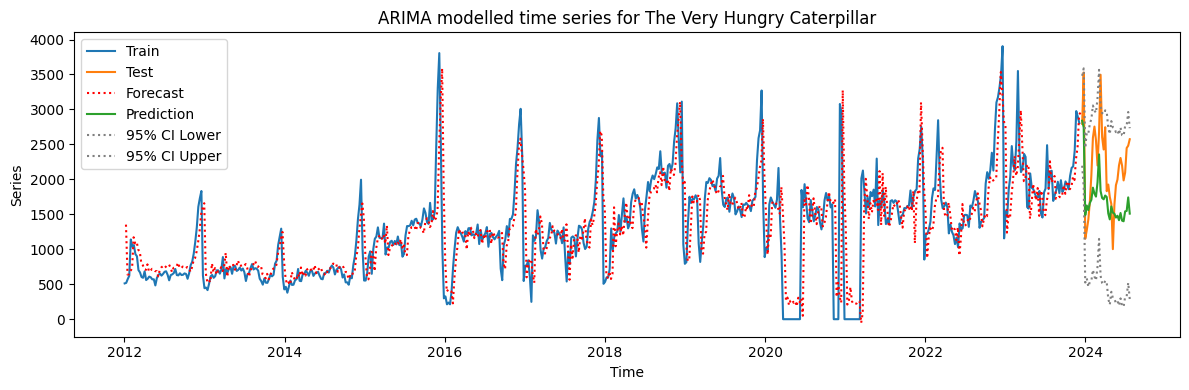

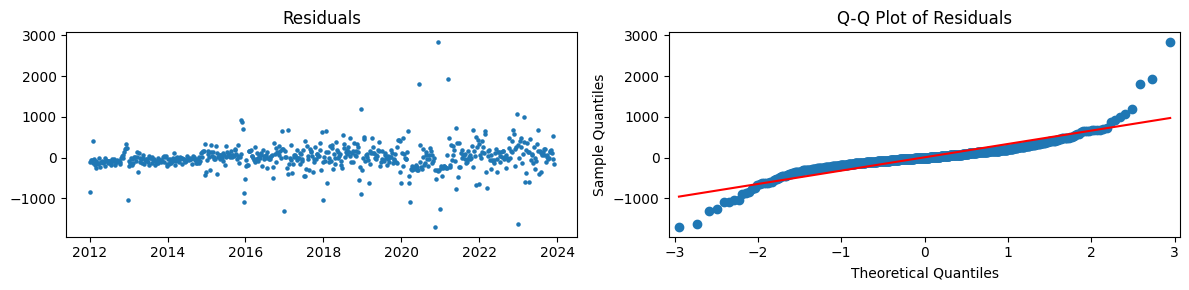

Train        Test
MAPE  7.587673e+18    0.249034
MAE   1.979902e+02  561.468983

In [ ]:
# Plot the predication from the auto ARIMA model for The Very Hungry Caterpillar
tvhc_arima_metrics = plot_arima_prediction(tvhc_train['Volume'],
                                           tvhc_test['Volume'],
                                           tvhc_arima_model,
                                           tvhc_arima_predictions,
                                           'The Very Hungry Caterpillar')

In [ ]:
# Create dataframe to store metrics
tvhc_metrics_df = pd.DataFrame(tvhc_arima_metrics['Test'])
tvhc_metrics_df.columns = ['ARIMA']

The auto ARIMA for _'The Very Hungry Caterpillar'_ favoured an ARIMA(1,0,0)(2,0,1)[52] model with MAPE of 24.9 % and a MAE of 561. The AR(1) is consistent with the ACF and PACF analysis. It should be noted the AIC is very close to a number of other models, for example ARIMA(1,0,0)(1,0,2)[52] and ARIMA(1,0,1)(2,0,1)[52].

The p-value of 0.86 for the Ljung-Box test indicates no autocorrelation within the residuals. However, the p-value of zero for the Jarque-Bera test indicates that the residuals are not normally distributed. This is also shown by the very high Kurtosis (18.63) and Q-Q plot, suggesting a more 'peaked' distribution of the residuals. This non-normal distribution should be remembered if using this model and for any subsequent statistical tests that are utilised.

The predictions are reasonable, given that this time series is very noisy. The initial changes in magnitude (an increase, followed by a decrease and subsequent increase) are captured well. However, predictions for the last ~11 weeks are poor and significantly underestimate the actual sales volumes.

# Machine Leaning and Deep Learning Techniques

## XGBoost

### XGBoost Helper Functions
Some functions specific to the XGBoost analysis.

In [ ]:
def create_predictor_with_deseasonaliser_xgboost(sp=52, degree=1):
    """Create a pipeline with detrender and deseasonaliser.

    Args:
        sp (int, optional): Seasonal periodicity. Defaults to 52.
        degree (int, optional): Degree of the polynomial for detrending. Defaults to 1.

    Returns:
        sktime.forecasting.compose.TransformedTargetForecaster: A forecaster object
                                                                with detrender, deseasonaliser and XGBoost.
    """


    regressor = XGBRegressor(
        base_score=0.5,
        n_estimators=400,
        min_child_weight=1,
        max_depth=7,
        learning_rate=0.1,
        booster="gbtree",
        tree_method="exact",
        reg_alpha=0,
        subsample=0.5,
        validate_parameters=1,
        colsample_bylevel=1,
        colsample_bynode=1,
        colsample_bytree=1,
        gamma=0,
    )
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=52, strategy="recursive"),
            ),
        ]
    )

    return forecaster

In [ ]:
def grid_search_predictor(train, test, predictor, param_grid):
    """Perform a grid search with cross-validation.
        Args:
        train (pd.Series): The training data.
        test (pd.Series): The test data.
        predictor (sktime.forecasting.base.Forecaster): The forecaster object to use.
        param_grid (dict): The parameter grid to search over.

    Returns:
        pd.Series: The predicted values for the test set.
    """

    # Grid search on window_length
    # Increased initial_window size
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        predictor,
        strategy="refit",
        cv=cv,
        param_grid=param_grid,
        scoring=MeanAbsolutePercentageError(symmetric=True),
        error_score="raise",  # Added to display error if fit fails
    )
    gscv.fit(train)
    print(f"Best parameters: {gscv.best_params_}")

    # Forecast
    future_horizon = np.arange(len(test)) + 1
    predictions = gscv.predict(fh=future_horizon)

    return predictions

In [ ]:
def xgb_prediction(train, test, param_grid, sp=52, freq="W"):
    """Make predictions using XGBoost with deseasonalization and detrending.
        Args:
        train (pd.DataFrame): The training data with a 'Volume' column and a DatetimeIndex.
        test (pd.DataFrame): The test data with a 'Volume' column and a DatetimeIndex.
        param_grid (dict): The parameter grid to search over for XGBoost.
        sp (int, optional): Seasonal periodicity. Defaults to 52.
        freq (str, optional): Frequency of the time series. Defaults to "W" (weekly).

    Returns:
        pd.Series: The predicted values for the test set.
    """
    predictor = create_predictor_with_deseasonaliser_xgboost(sp=sp, degree=1)

    train.index = pd.PeriodIndex(train.index, freq=freq)
    # Perform a grid search
    predictions = grid_search_predictor(
        train["Volume"], test["Volume"], predictor, param_grid
    )
    train.index = train.index.to_timestamp()
    return predictions

### XGBoost - _'The Alchemist'_

In [ ]:
#Set the parameter grid to perform a grid search on a small subset of parameters.
param_grid = {"forecast__window_length": [52, 104, 156],
              "learning_rate": [0.01, 0.1],
              "max_depth": [3, 4, 5],
              "reg_alpha": [0, 0.1]}

In [ ]:
# Underatake XGBoost on The Alchemist training set and predict the last 32 weeks
alchemist_predictions = xgb_prediction(alchemist_train, alchemist_test, param_grid)

Best parameters: {'forecast__window_length': 104, 'learning_rate': 0.01, 'max_depth': 4, 'reg_alpha': 0}


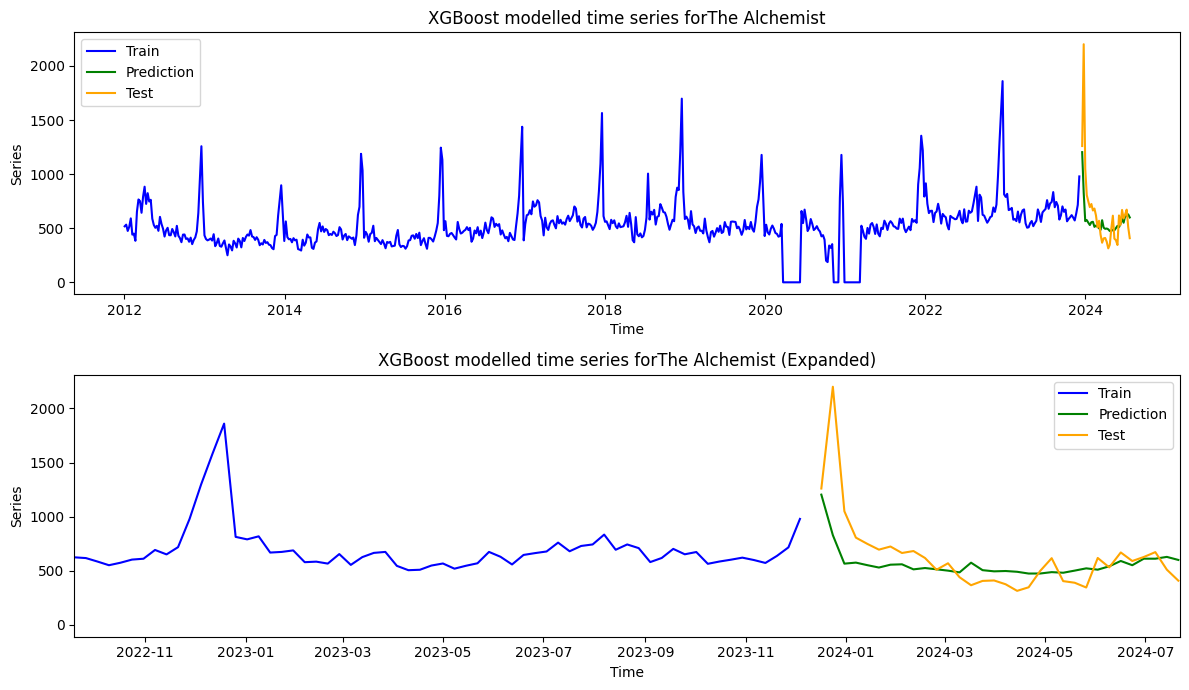

Test
MAPE    0.239177
MAE   159.925703

In [ ]:
# Plot and evaluate XGBoost predictions
alchemist_xgb_metrics = plot_and_evaluate(alchemist_train['Volume'],
                                          alchemist_test['Volume'],
                                          alchemist_predictions,
                                          'XGBoost modelled time series for The Alchemist',
                                          freq='W')

The predictions from XGBoost are a slight improvement on the predictions from auto ARIMA, with respect to MAPE with a decrease to 23.9 % from 25.3 %. However, there is a slight increase in MAE from 142 for the auto ARIMA to 160. Like the auto ARIMA model, the initial, seasonal spike in sales is underestimated. Improvements in the MAPE for XGBoost are likely due to the predictions better capturing the rolling average of the sales volumes for the last two-thirds of the test set. The auto ARIMA model underestimated this section of the test set.

### XGBoost - _'The Very Hungry Caterpillar'_

In [ ]:
#Set the window_length values to perform a grid search.
param_grid = {"forecast__window_length": [52, 104, 156],
              "learning_rate": [0.01, 0.1],
              "max_depth": [3, 4, 5],
              "reg_alpha": [0, 0.1]}

In [ ]:
# Underatake XGBoost on The Very Hungry Caterpillar training set and predict the last 32 weeks
tvhc_predictions = xgb_prediction(tvhc_train, tvhc_test, param_grid)

Best parameters: {'forecast__window_length': 156, 'learning_rate': 0.01, 'max_depth': 3, 'reg_alpha': 0}


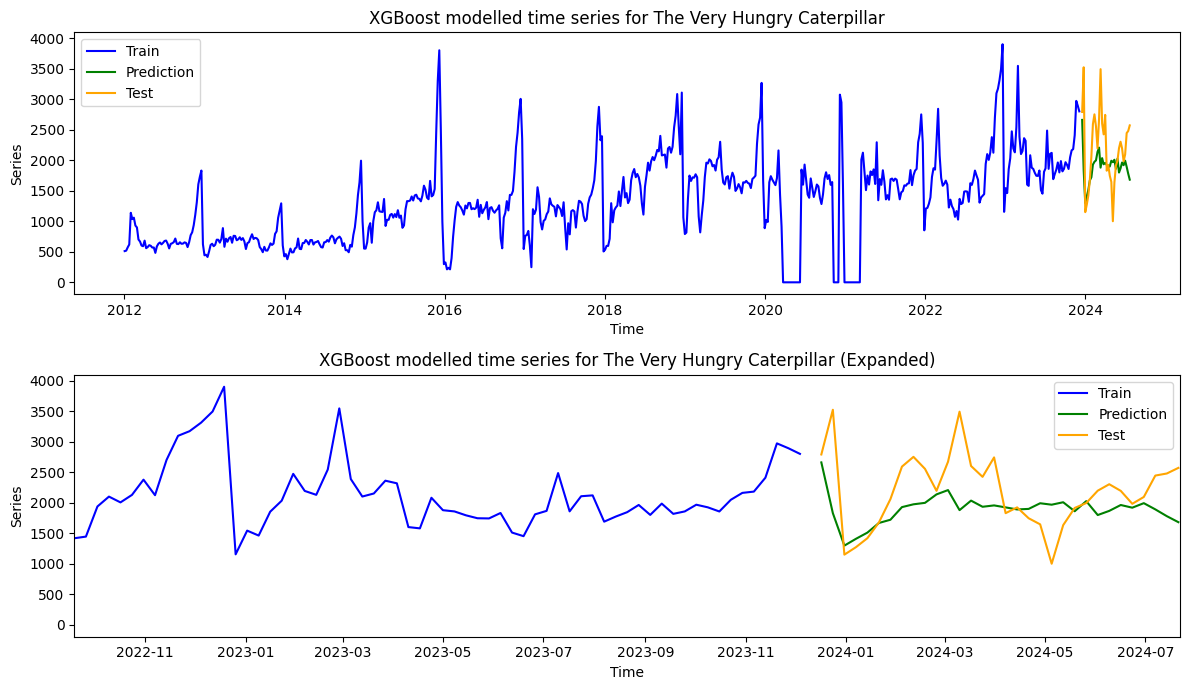

Test
MAPE    0.191939
MAE   436.584055

In [ ]:
# Plot and evaluate XGBoost predictions
tvhc_xgb_metrics = plot_and_evaluate(tvhc_train['Volume'],
                                     tvhc_test['Volume'],
                                     tvhc_predictions,
                                     'XGBoost modelled time series for The Very Hungry Caterpillar',
                                     freq='W')




The predictions from XGBoost are a significant improvement on the predictions from auto ARIMA, with a reduction in MAPE to 19.2 % from 24.9 %. In addition the MAE has decreased to 437 from 561 for the ARIMA model. The intitial downward trend in the dataset is captured well in this model. However the subsequent increase in sales is not captured as well here. The improvement in MAPE is likely due to the XGBoost better predicting 'average' sales towards the very end of the test data, where the auto ARIMA model fails to predict the last 11 weeks well.

## LSTM

### LSTM Helper Functions
Some functions specific to the LSTM analysis.

In [ ]:
def LSTM_preprocess(df):
    """Reshape and normalise data prior to use with LSTM.

    Args:
        df (pd.DataFrame): The input DataFrame to be processed.

    Returns:
        tuple: A tuple containing the scaled data and the scaler object.
    """
    X = df.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_X = scaler.fit_transform(X)
    return scaled_X, scaler

In [ ]:
def create_input_sequences(lookback, forecast, sequence_data):
    """Creates input and output sequences for LSTM.

    Args:
        lookback (int): The number of previous time steps to use as input.
        forecast (int): The number of time steps to forecast.
        sequence_data (np.ndarray): The time series data.

    Returns:
        tuple: A tuple containing the input and output sequences.
    """
    input_sequences = []
    output_sequences = []

    for i in range(lookback, len(sequence_data) - forecast + 1):
        input_sequences.append(sequence_data[i - lookback : i])
        output_sequences.append(sequence_data[i : i + forecast])

    return np.array(input_sequences), np.array(output_sequences)

In [ ]:
def build_model(hp):
    """Builds an LSTM model with hyperparameters defined by Keras Tuner.

    Args:
        hp (kt.HyperParameters): Keras Tuner hyperparameters object.

    Returns:
        tf.keras.Model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(Input(shape=(multi_step_lookback, 1)))
    model.add(
        LSTM(
            units=hp.Int("units", min_value=40, max_value=100, step=20),
            return_sequences=True,
        )
    )
    model.add(Dropout(hp.Float("dropout", min_value=0.1, max_value=0.3, step=0.1)))
    model.add(LSTM(units=hp.Int("units_2", min_value=40, max_value=100, step=20)))
    model.add(Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.3, step=0.1)))
    model.add(Dense(multi_step_forecast))

    model.compile(
        loss="mean_squared_error",
        metrics=["mse"],
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("learning_rate", min_value=1e-4, max_value=1e-2)
        ),
    )
    return model

In [ ]:
def tune_fit_LSTM(
    sequence_data, multi_step_lookback, multi_step_forecast, max_trials, epochs, validation_split
):
    """Tunes and fits an LSTM model using Keras Tuner.

    Args:
        sequence_data (np.ndarray): The time series data.
        multi_step_lookback (int): The number of previous time steps to use as input.
        multi_step_forecast (int): The number of time steps to forecast.
        max_trials (int): The maximum number of hyperparameter combinations to try.
        epochs (int): The number of training epochs.
        validation_split (float): The fraction of data to use for validation.

    Returns:
        tf.keras.Model: The best LSTM model found by Keras Tuner.
    """
    multi_step_input, multi_step_output = create_input_sequences(
        multi_step_lookback, multi_step_forecast, sequence_data
    )

    tuner = kt.RandomSearch(
        build_model,
        objective="mse",
        max_trials=max_trials,
        project_name="lstm_tuning",
        overwrite=True,
        seed=42,
    )

    # Perform hyperparameter search
    tuner.search(
        multi_step_input,
        multi_step_output,
        epochs=epochs,
        validation_split=validation_split,  # Use validation_split argument
        batch_size=32,
    )

    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]
    print(best_model.summary())

    return best_model

In [ ]:
def get_predictions(best_model, sequence_data, multi_step_lookback, scaler):
    """Gets predictions from the trained LSTM model.

    Args:
        best_model (tf.keras.Model): The trained LSTM model.
        sequence_data (np.ndarray): The time series data.
        multi_step_lookback (int): The number of previous time steps used as input.
        scaler (MinMaxScaler): The scaler object used for data normalization.

    Returns:
        np.ndarray: The predicted values.
    """
    multi_step_last_input = sequence_data[-multi_step_lookback:]
    multi_step_last_input = multi_step_last_input.reshape(1, multi_step_lookback, 1)
    predictions = best_model.predict(multi_step_last_input)
    predictions = predictions.reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    return predictions

In [ ]:
# Set size of validation and train samples for model fitting
multi_step_lookback = 104
multi_step_forecast = 32

### LSTM - _'The Alchemist'_

In [ ]:
# Scale and process the training dataset
alchemist_sequence_data, scaler = LSTM_preprocess(alchemist_train[["Volume"]])

In [ ]:
# Using LSTM model the training set
alchemist_lstm_best_model = tune_fit_LSTM(alchemist_sequence_data,
                           multi_step_lookback,
                           multi_step_forecast,
                           max_trials=20,
                           epochs=500,
                           validation_split=0.2)

Trial 20 Complete [00h 01m 34s]
mse: 0.002319175750017166

Best mse So Far: 0.0007774496916681528
Total elapsed time: 00h 32m 11s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 104, 100)            │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 104, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           3,232 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,432 (486.06 KB)

 Trainable params: 124,432 (486.06 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Using the LSTM model created above predict the last 32 weeks (the test set)
alchemist_lstm_predictions = get_predictions(alchemist_lstm_best_model,
                                             alchemist_sequence_data,
                                             multi_step_lookback,
                                             scaler)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


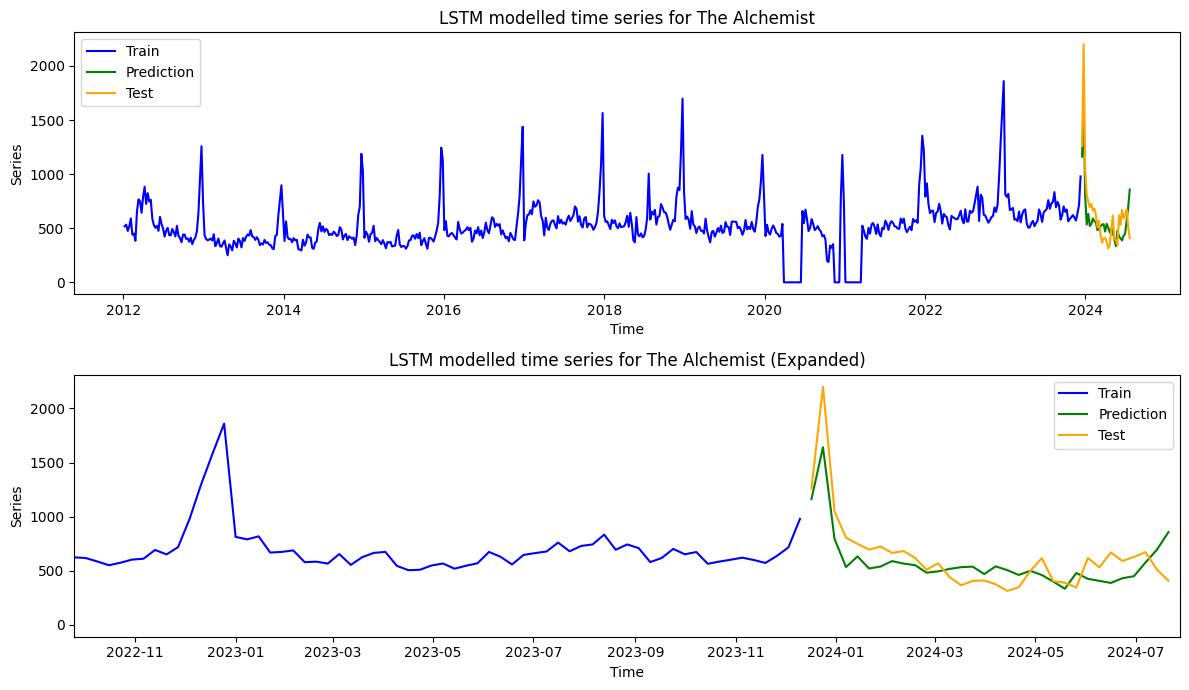

Test
MAPE    0.267397
MAE   154.473257

In [ ]:
alchemist_lstm_metrics = plot_and_evaluate(alchemist_train['Volume'],
                                           alchemist_test['Volume'],
                                           alchemist_lstm_predictions,
                                           'LSTM modelled time series for The Alchemist',
                                           freq='W')

The predictions for _'The Alchemist'_ from LSTM lead to the worst MAPE compared to XGBoost and ARIMA, with a MAPE of 26.7%. However, the MAE of 154 sits between the ARIMA and XGBoost models. Although it is noted that initial LSTM predictions in the first part of the test set model the seasonal increase in sales well the predictions towards the end of the test set are poor. The LSTM model is also significantly computational intensive to train.

### LSTM - _'The Very Hungry Caterpillar'_

In [ ]:
# Scale and process the training dataset
tvhc_sequence_data, scaler = LSTM_preprocess(tvhc_train[["Volume"]])

In [ ]:
# Using LSTM model the training set
tvhc_lstm_best_model = tune_fit_LSTM(tvhc_sequence_data,
                           multi_step_lookback,
                           multi_step_forecast,
                           max_trials=20,
                           epochs=500,
                           validation_split=0.2)

Trial 20 Complete [00h 01m 35s]
mse: 0.0040226709097623825

Best mse So Far: 0.001371114864014089
Total elapsed time: 00h 32m 10s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 104, 100)            │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 104, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           3,232 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,432 (486.06 KB)

 Trainable params: 124,432 (486.06 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Using the LSTM model created above predict the last 32 weeks (the test set)
tvhc_lstm_predictions = get_predictions(tvhc_lstm_best_model, tvhc_sequence_data, multi_step_lookback, scaler)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


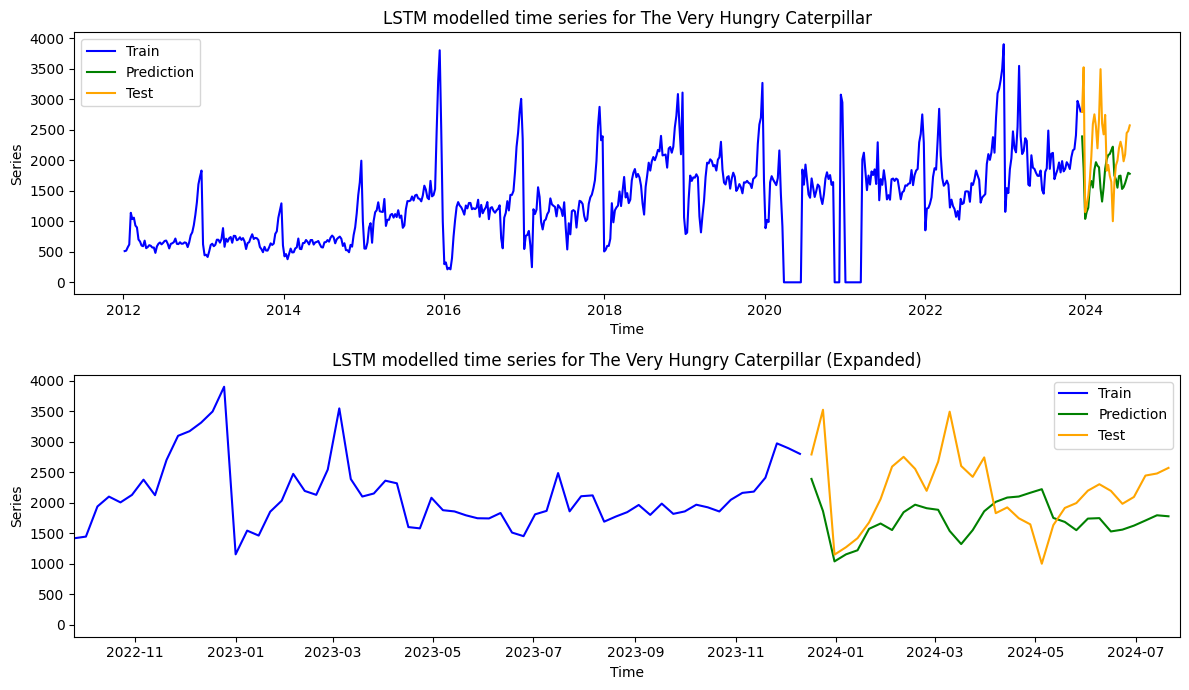

Test
MAPE    0.272813
MAE   613.229916

In [ ]:
tvhc_lstm_metrics = plot_and_evaluate(tvhc_train['Volume'],
                                      tvhc_test['Volume'],
                                      tvhc_lstm_predictions,
                                      'LSTM modelled time series for The Very Hungry Caterpillar',
                                      freq='W')

The predictions for _'The Very Hungry Caterpillar'_ from LSTM are very poor and have the worst MAPE and MAE compared to XGBoost and ARIMA, with a MAPE of 27.3% and MAE of 613. The LSTM predictions predict the initial downward trend, but after this the trends predicted appear to be opposite to the test set and bear little resemble to these actual values.

# Hybrid Model

### Sequential (SARIMA and LSTM)

In this sequential model, the seasonal ARIMA models from [above](#scrollTo=BiB-MatcK3W2) are used, and the residuals from these models are modelled with LSTM. The final model is constructed as a summation of the seasonal ARIMA model plus the residuals modelled by LSTM.

### Sequential - _'The Alchemist'_


In [ ]:
# Set size of validation and train samples for model fitting
multi_step_lookback = 104
multi_step_forecast = 32

In [ ]:
# Scale and process the residuals data captured in the seasonal ARIMA model earlier
alchemist_residuals_sequence_data, scaler = LSTM_preprocess(alchemist_arima_residuals)

In [ ]:
# Using LSTM Model the residuals captured in the SARIMA model earlier
alchemist_residuals_best_model = tune_fit_LSTM(alchemist_residuals_sequence_data,
                           multi_step_lookback,
                           multi_step_forecast,
                           max_trials=20,
                           epochs=500,
                           validation_split=0.2)

Trial 20 Complete [00h 01m 46s]
mse: 0.005171238910406828

Best mse So Far: 0.000605225854087621
Total elapsed time: 00h 33m 07s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 104, 100)            │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 104, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           3,232 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,432 (486.06 KB)

 Trainable params: 124,432 (486.06 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Get predictions of the residuals for the next 32 weeks
alchemist_lstm_resid_predictions = get_predictions(alchemist_residuals_best_model, alchemist_residuals_sequence_data, multi_step_lookback, scaler)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


In [ ]:
# Calculate prediction for sequential hybrid model
alchemist_seq_hybrid = alchemist_arima_predictions[0] + alchemist_lstm_resid_predictions.flatten()

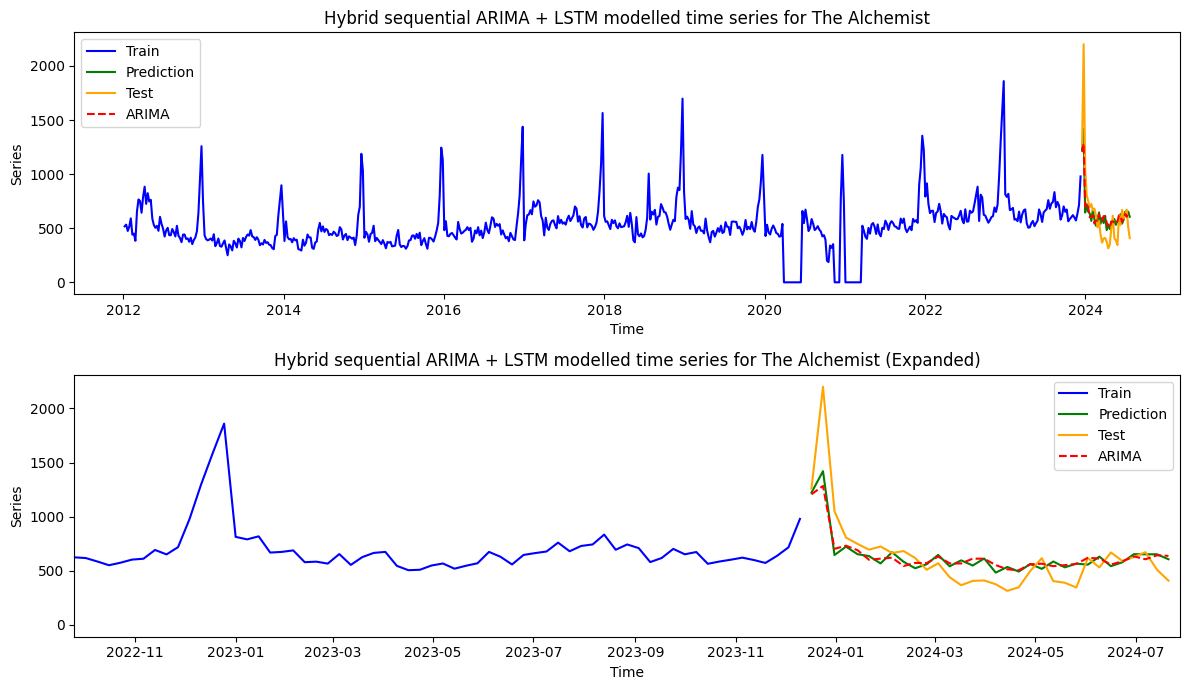

Test
MAPE    0.251165
MAE   140.347536

In [ ]:
# Plot and evaluate the sequential model
alchemist_seq_hybrid_metrics = plot_and_evaluate(alchemist_train['Volume'],
                                      alchemist_test['Volume'],
                                      alchemist_seq_hybrid,
                                      'Hybrid sequential ARIMA + LSTM modelled time series for The Alchemist',
                                        freq='W',
                                        benchmark = alchemist_arima_predictions[0],
                                        benchmark_lab="ARIMA")

This sequential model has led to improvements compared to the standalone seasonal ARIMA models with a MAPE of 25.1% and MAE of 140. This is compared to the MAPE of 25.3% and MAE of 142 for the seasonal ARIMA model. However, the small gains come at a significant increase in computational cost compared to using SARIMA in isolation.

### Sequential - _'The Very Hungry Caterpillar'_

In [ ]:
# Scale and process the residuals data captured in the seaonal ARIMA model earlier
tvhc_residuals_sequence_data, scaler = LSTM_preprocess(tvhc_arima_residuals)

In [ ]:
# Using LSTM Model the residuals captured in the seasonal ARIMA model earlier
tvhc_residuals_best_model = tune_fit_LSTM(tvhc_residuals_sequence_data,
                           multi_step_lookback,
                           multi_step_forecast,
                           max_trials=20,
                           epochs=500,
                           validation_split=0.2)

Trial 20 Complete [00h 01m 36s]
mse: 0.0029710971284657717

Best mse So Far: 0.00040884254849515855
Total elapsed time: 00h 33m 45s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 104, 100)            │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 104, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           3,232 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,432 (486.06 KB)

 Trainable params: 124,432 (486.06 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Get predictions of the residuals for the next 32 weeks
tvhc_LSTM_resid_predictions = get_predictions(tvhc_residuals_best_model, tvhc_residuals_sequence_data, multi_step_lookback, scaler)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


In [ ]:
# Calculate prediction for sequential hybrid model
tvhc_seq_hybrid = tvhc_arima_predictions[0] + tvhc_LSTM_resid_predictions.flatten()

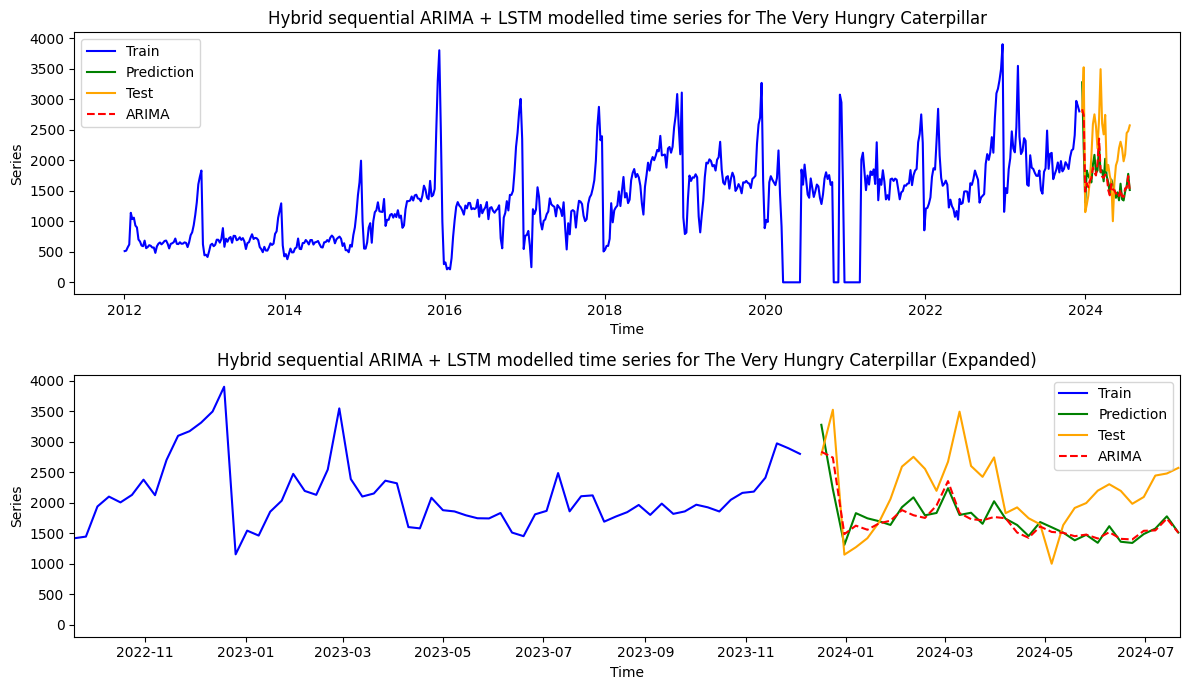

Test
MAPE    0.261881
MAE   589.414057

In [ ]:
# Plot and evaluate the sequential model
tvhc_seq_hybrid_metrics = plot_and_evaluate(tvhc_train['Volume'],
                                      tvhc_test['Volume'],
                                      tvhc_seq_hybrid,
                                      'Hybrid sequential ARIMA + LSTM modelled time series for The Very Hungry Caterpillar',
                                        freq='W',
                                        benchmark = tvhc_arima_predictions[0],
                                        benchmark_lab="ARIMA")

This sequential model has led to worse performance (MAPE of 26.2% and MAE of 589) compared to the standalone seasonal ARIMA which had a MAPE of 24.9% and MAE of 561. The LSTM must have modelled the residuals poorly and it may benefit from further optimisation and training.

### Parallel  (SARIMA and LSTM)

In this parallel model, the models from seasonal [ARIMA](#scrollTo=BiB-MatcK3W2) and [LSTM](#scrollTo=m2fpGYMBsjAQ) above are used. These are then added using equal weights (no attempt at tuning weights was attempted) to create the final parallel hybrid model.

### Parallel - _'The Alchemist'_

In [ ]:
# Calculate prediction for sequential hybrid model
alchemist_para_hybrid = 0.5*alchemist_arima_predictions[0] + 0.5*alchemist_lstm_predictions.flatten()

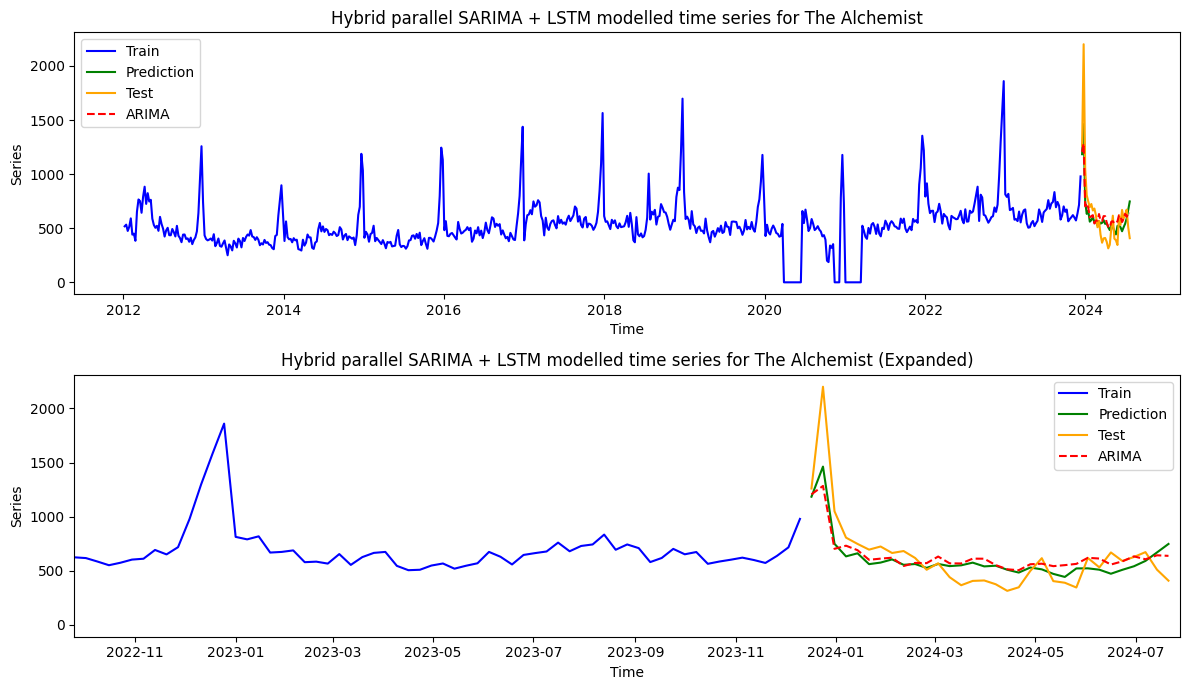

Test
MAPE    0.244936
MAE   140.777444

In [ ]:
alchemist_para_hybrid_metrics = plot_and_evaluate(alchemist_train['Volume'],
                                      alchemist_test['Volume'],
                                      alchemist_para_hybrid,
                                      'Hybrid parallel SARIMA + LSTM modelled time series for The Alchemist',
                                        benchmark = alchemist_arima_predictions[0],
                                        benchmark_lab="ARIMA")

This parallel model had an MAPE of 24.5% and MAE of 141, which is an improvement on the LSTM model alone and a marginal improvement on the original seasonal ARIMA models. Its performance is comparable to that of the sequential model above. With simple tuning of the weights for the addition of the LSTM and ARIMA models, improvements in the model could be made.

### Parallel - _'The Very Hungry Caterpillar'_

In [ ]:
# Calculate prediction for parallel hybrid model
tvhc_para_hybrid = 0.5*tvhc_arima_predictions[0] + 0.5*tvhc_lstm_predictions.flatten()

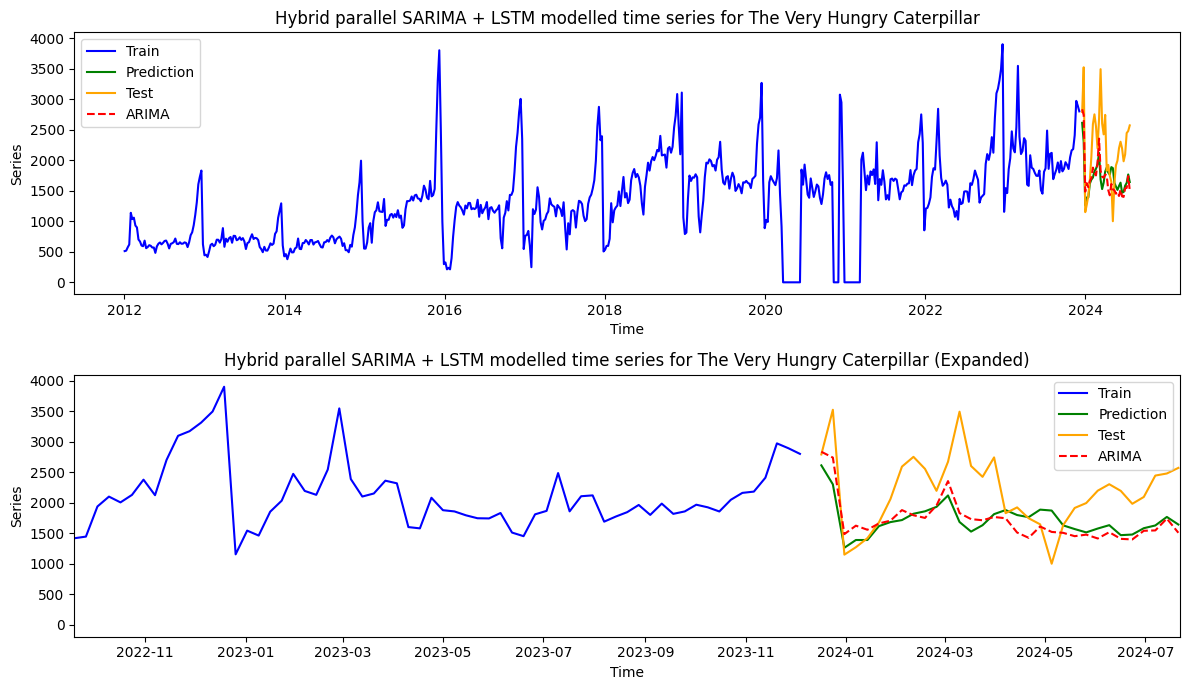

Test
MAPE    0.238807
MAE   552.061854

In [ ]:
tvhc_para_hybrid_metrics = plot_and_evaluate(tvhc_train['Volume'],
                                      tvhc_test['Volume'],
                                      tvhc_para_hybrid,
                                      'Hybrid parallel SARIMA + LSTM modelled time series for The Very Hungry Caterpillar',
                                        freq='W',
                                        benchmark = tvhc_arima_predictions[0],
                                        benchmark_lab="ARIMA")

This parallel model had a MAPE of 23.9% and an MAE of 552, which is an improvement on both the standalone LSTM and SARIMA models. Its performance is also better than that of the sequential model above, but still lags behind the XGBoost model.

# Monthly Prediction

Here the sales data is resampled as monthly sales data and the seasonal ARIMA and XGBoost models are fitted to this new dataset.

In [ ]:
# Resample the The Alchemist data to monthly
alchemist_df2 = sales_sheets["F Adult Fiction"][sales_sheets["F Adult Fiction"]['ISBN'] == alchemist_ISBN]
alchemist_df_monthly = resample_sales(alchemist_df2,'M')
# Resample the The Very Hungry Caterpillar data to monthly
tvhc_df2 = sales_sheets["Y Children's, YA & Educational"][sales_sheets["Y Children's, YA & Educational"]['ISBN'] == tvhc_ISBN]
tvhc_df_monthly = resample_sales(tvhc_df2,'M')


In [ ]:
# Reduce datasets to entries after 2012-01-01
alchemist_df_monthly = alchemist_df_monthly[alchemist_df_monthly['End Date'] > pd.to_datetime('2012-01-01')]
tvhc_df_monthly = tvhc_df_monthly[tvhc_df_monthly['End Date'] > pd.to_datetime('2012-01-01')]

In [ ]:
# Create dataframe indices from the 'End Date' field
alchemist_df_monthly.set_index('End Date', inplace=True)
tvhc_df_monthly.set_index('End Date', inplace=True)

In [ ]:
plot = px.line(alchemist_df_monthly, x=alchemist_df_monthly.index, y='Volume', title='Monthly Sales Volumes for The Alchemist')
plot.show()

In [ ]:
plot = px.line(tvhc_df_monthly, x=tvhc_df_monthly.index, y='Volume', title='Monthly Sales Volumes for The Very Hungry Caterpillar')
plot.show()

In [ ]:
# Split data into train and test
tvhc_train_monthly, tvhc_test_monthly = test_train_split(tvhc_df_monthly, 8)
alchemist_train_monthly, alchemist_test_monthly = test_train_split(alchemist_df_monthly, 8)

After resampling to monthly, the seasonal trends in sales for _'The Alchemist'_ can still be seen. However, their height above the rolling mean has been reduced due to this 'averaging' effect. For _'The Very Hungry Caterpillar'_ sales, the seasonal trends are now much more challenging to see through the natural variance of the dataset.

## XGBoost

Here the same functions and workflow are utilised for the monthly predictions as were used for the weekly predictions [above](#scrollTo=11IOpMRwjYJm).

### Monthly - _'The Alchemist'_

In [ ]:
# Set the parameter grid to undertake the grid search in
param_grid = {"forecast__window_length": [12, 24, 36],
              "learning_rate": [0.01, 0.1],
              "max_depth": [3, 4, 5],
              "reg_alpha": [0, 0.1]}

# Model the monthly data using XGBoost
alchemist_xgb_predictions_monthly = xgb_prediction(alchemist_train_monthly, alchemist_test_monthly, param_grid, sp=12, freq ='M')

Best parameters: {'forecast__window_length': 24, 'learning_rate': 0.01, 'max_depth': 3, 'reg_alpha': 0.1}


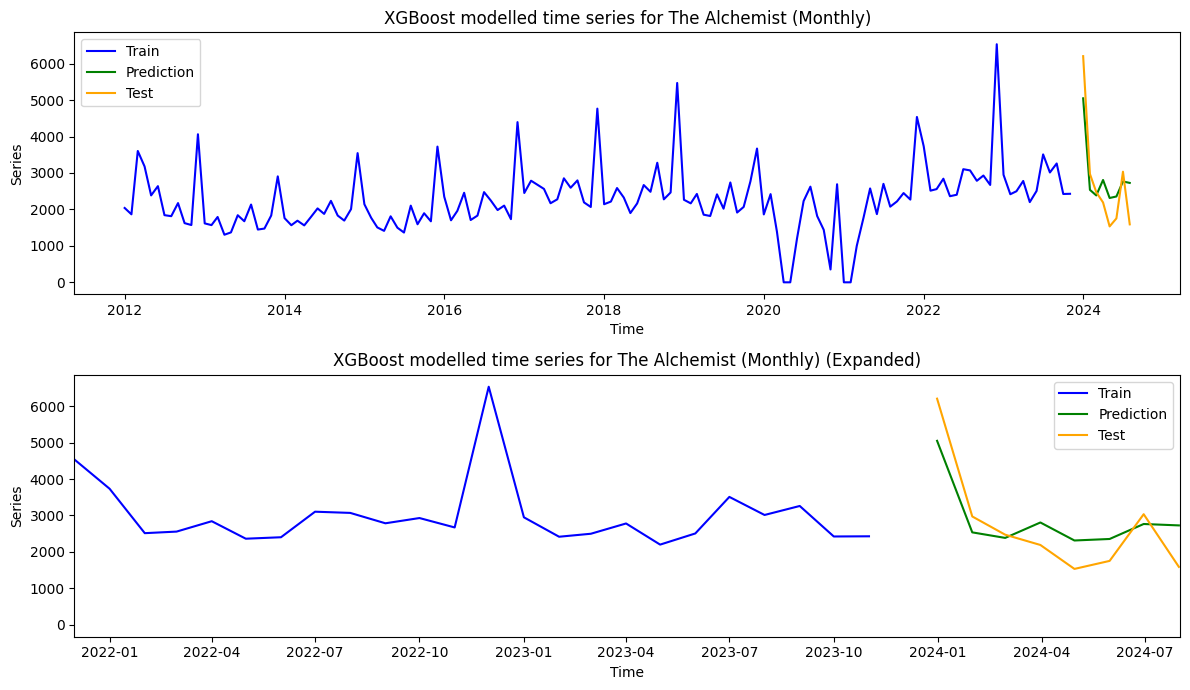

Test
MAPE    0.288241
MAE   635.785094

In [ ]:
alchemist_xgb_metrics_monthly = plot_and_evaluate(alchemist_train_monthly['Volume'],
                                     alchemist_test_monthly['Volume'],
                                     alchemist_xgb_predictions_monthly,
                                     'XGBoost modelled time series for The Alchemist (Monthly)',
                                        freq ='M'
                                        )

Using the monthly dataset a MAPE of 28.8 % and MAE of 636 is acheived with XGBoost. Adjusting the MAE (by dividing by 4.33) to allow comparisons with the weekly MAE it yields 147. Quantitatively this is comparable to predictions using the weekly dataset. But the metrics do suggest it is one of the worse performing of the models. However it is difficult to make direct comparisons due to the difference granuality of the datasets.

Visually the predictions for the last 8 weeks do appear to model the patterns in a reasonable way. The magnitude of the intial increase in sales during this test set seems to have been captured better than for the weekly dataset. This suggests there is some feasibility in making longer term predictions by aggregating the data.

### Monthly - _'The Very Hungry Caterpillar'_

In [ ]:
# Set the parameter grid to undertake the grid search in
param_grid = {"forecast__window_length": [12, 24, 36],
              "learning_rate": [0.01, 0.1],
              "max_depth": [3, 4, 5],
              "reg_alpha": [0, 0.1]}

# Model the monthly data using XGBoost
tvhc_xgb_predictions_monthly = xgb_prediction(tvhc_train_monthly, tvhc_test_monthly, param_grid, sp=12, freq ='M')

Best parameters: {'forecast__window_length': 36, 'learning_rate': 0.01, 'max_depth': 3, 'reg_alpha': 0.1}


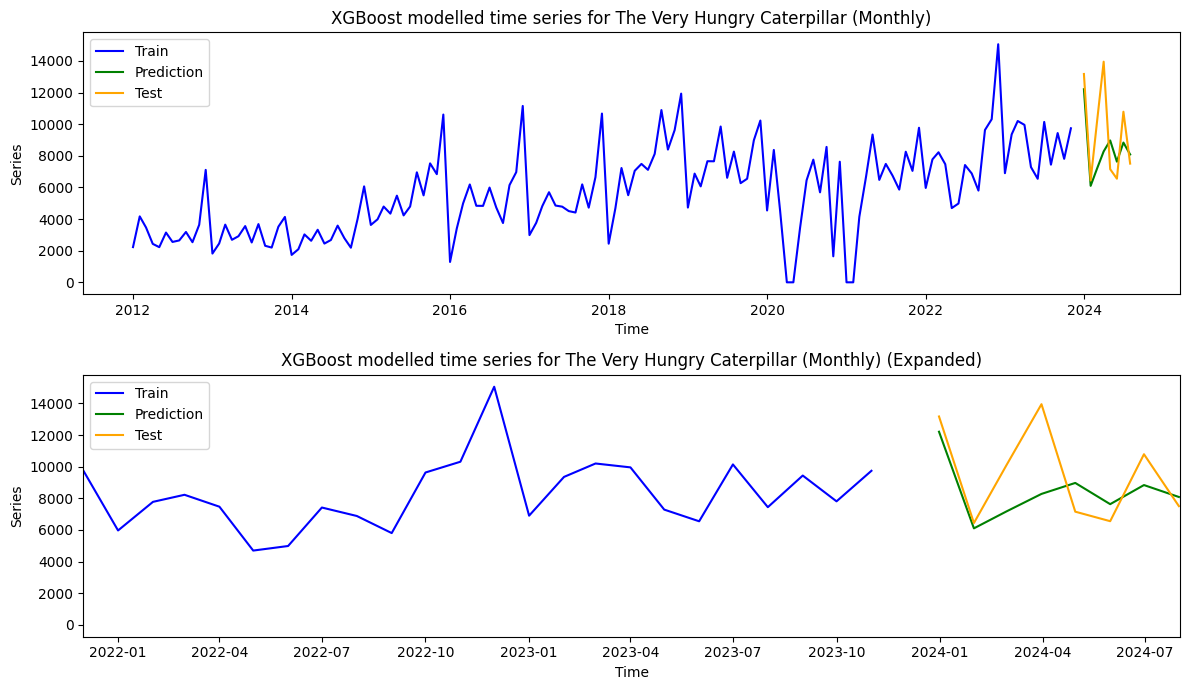

Test
MAPE     0.187330
MAE   1916.040263

In [ ]:
tvhc_XGB_metrics = plot_and_evaluate(tvhc_train_monthly['Volume'],
                                     tvhc_test_monthly['Volume'],
                                     tvhc_xgb_predictions_monthly,
                                     'XGBoost modelled time series for The Very Hungry Caterpillar (Monthly)',
                                     freq ='M'
                                     )

Using the monthly dataset a MAPE of 18.7 % and MAE of 1916 is acheived with XGBoost. Adjusting the MAE (by dividing by 4.33) to allow comparisons with the weekly MAE it yields 442. Quantitatively, this is comparable to predictions using the weekly dataset and appears to be one of the best-performing models. However it is difficult to make direct comparisons due to the difference granuality of the datasets.

Visually the predictions for the last 8 weeks do appear to model the patterns in a reasonable way, capturing the inital trends in the test set.

## ARIMA

Here the same functions and workflow are utilised for the monthly predictions as were used for the weekly predictions [above](#scrollTo=BiB-MatcK3W2).

### Monthly - _'The Alchemist'_

In [ ]:
# Fit the auto ARIMA model to The Alchemist
alchemist_arima_predictions_monthly,
alchemist_arima_residuals_monthly,
alchemist_arima_model_monthly = auto_arima_fit(
    alchemist_train_monthly['Volume'],
    alchemist_test_monthly['Volume'],
    m=12
    )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2352.814, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2321.034, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2312.014, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2638.083, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2342.425, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2312.258, Time=0.35 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=2301.591, Time=0.64 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=2302.842, Time=1.50 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=2325.519, Time=0.56 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=2293.794, Time=0.76 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=2308.339, Time=0.30 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=2294.945, Time=2.60 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=2298.312, Time=1.63 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=2294.749, Time=0.92 sec
 ARIMA(2,0,1)(0,0,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  143
Model:             SARIMAX(1, 0, 1)x(0, 0, [1, 2], 12)   Log Likelihood               -1140.897
Date:                                 Tue, 14 Jan 2025   AIC                           2293.794
Time:                                         21:39:10   BIC                           2311.571
Sample:                                     01-01-2012   HQIC                          2301.018
                                          - 11-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1171.8170    376.815      3.110      0.002     433.273    1910.361
ar.L1          0.5055      0.170      2.974      0.003       0.172       0.839
ma.L1         -0.0628      0.191     -0.329      0.742      -0.438       0.312
ma.S.L12       0.5075      0.065      7.806      0.000       0.380       0.635
ma.S.L24       0.3685      0.096      3.852      0.000       0.181       0.556
sigma2      4.791e+05    5.2e+04      9.222      0.000    3.77e+05    5.81e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                39.92
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.90   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

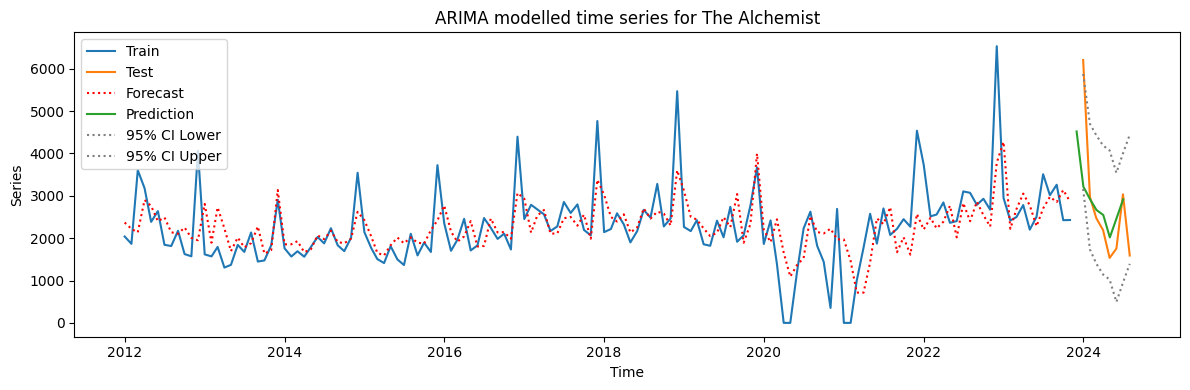

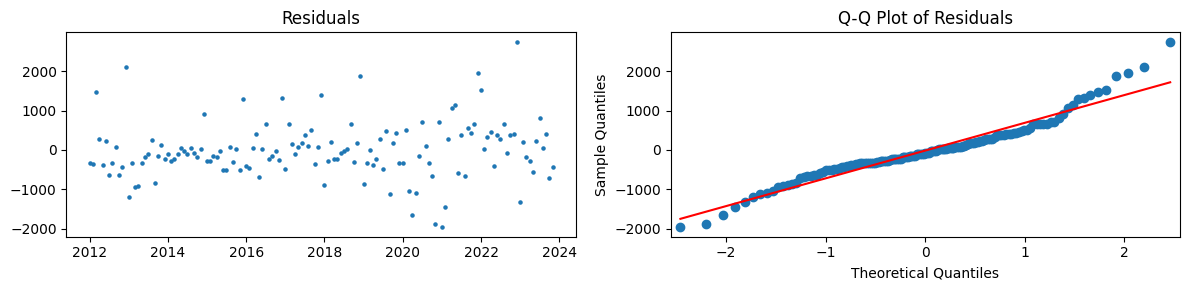

Train        Test
MAPE  1.947123e+19    0.322422
MAE   5.008416e+02  751.359721

In [ ]:
# Plot the predication from the auto ARIMA model for The Alchemist monthly sales
alchemist_arima_metrics_monthly = plot_arima_prediction(alchemist_train_monthly['Volume'],
                                           alchemist_test_monthly['Volume'],
                                           alchemist_arima_model_monthly,
                                           alchemist_arima_predictions_monthly,
                                           'The Alchemist')

The auto ARIMA for 'The Alchemist' using the monthly dataset favoured an ARIMA(1,0,1)(0,0,2)[12] model with a MAPE of 32.2 % and an MAE of 751. Adjusting the MAE (by dividing by 4.33) to allow comparisons with the weekly MAE yields 173. Quantitatively, this is significantly worse than predictions using the weekly dataset. Although not normal, the residuals from this model are closer to a normal distribution than from modelling with a weekly dataset. However, it isn't easy to make direct comparisons due to the different granularity of the datasets.

Visually the predictions for the last 8 weeks appear to model the patterns. in a reasonable way, capturing the inital trends in the test set. This suggests there is some feasibility in making longer term predictions by aggregating the data.

### Monthly - _'The Very Hungry Caterpillar'_

In [ ]:
# Fit the auto ARIMA model to The Very Hungry Caterpillar
tvhc_arima_predictions_monthly, tvhc_arima_residuals_monthly, tvhc_arima_model_monthly = auto_arima_fit(
    tvhc_train_monthly['Volume'], tvhc_test_monthly['Volume'], m=12
    )


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2677.169, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2611.875, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2626.269, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2909.537, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2632.787, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2613.384, Time=0.39 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2606.647, Time=0.38 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2611.451, Time=0.09 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=2603.827, Time=0.33 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=2656.038, Time=0.24 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=2598.952, Time=0.33 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=2608.112, Time=0.11 sec
 ARIMA(2,0,0)(1,0,2)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  143
Model:             SARIMAX(2, 0, 1)x(0, 0, [1, 2], 12)   Log Likelihood               -1291.295
Date:                                 Tue, 14 Jan 2025   AIC                           2596.589
Time:                                         21:40:54   BIC                           2617.329
Sample:                                     01-01-2012   HQIC                          2605.017
                                          - 11-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1745.5177    973.919      1.792      0.073    -163.329    3654.364
ar.L1          0.5335      0.354      1.509      0.131      -0.160       1.227
ar.L2          0.1635      0.207      0.790      0.429      -0.242       0.569
ma.L1         -0.0742      0.364     -0.204      0.838      -0.787       0.639
ma.S.L12       0.3128      0.083      3.750      0.000       0.149       0.476
ma.S.L24       0.3123      0.082      3.804      0.000       0.151       0.473
sigma2      3.979e+06    4.1e+05      9.701      0.000    3.17e+06    4.78e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.60
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.26   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

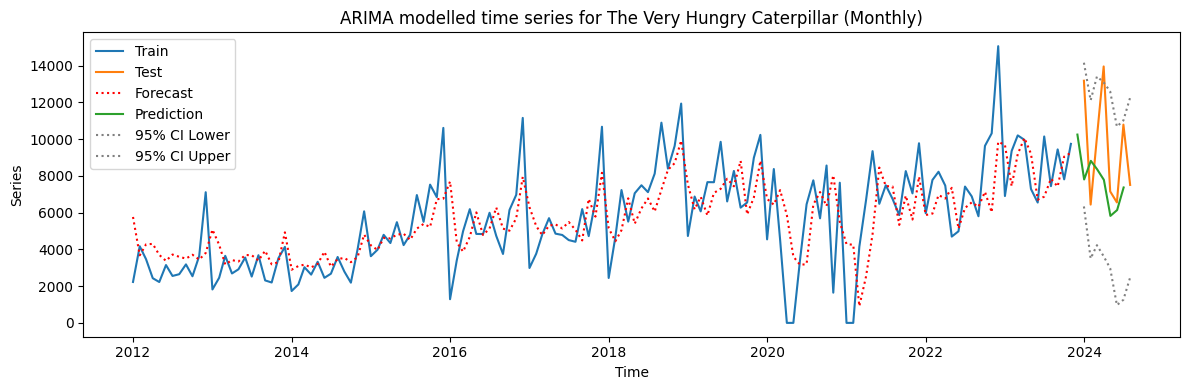

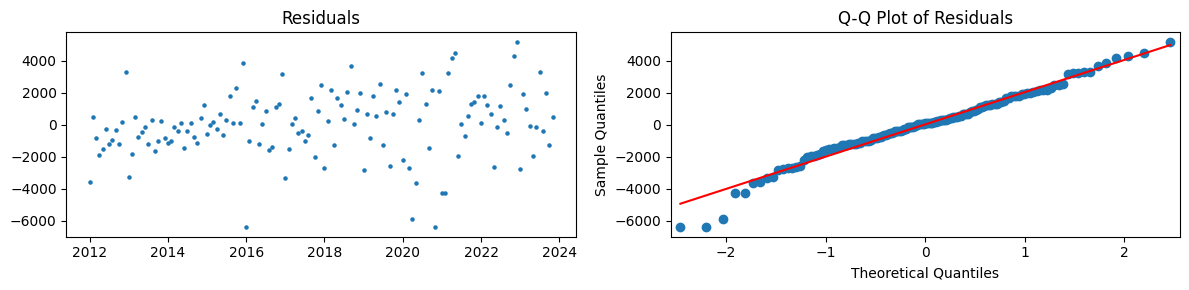

Train         Test
MAPE  5.670749e+19     0.201541
MAE   1.510215e+03  2166.003401

In [ ]:
# Plot the predication from the auto ARIMA model for The Very Hungry Caterpillar
tvhc_arima_metrics_monthly = plot_arima_prediction(tvhc_train_monthly['Volume'],
                                           tvhc_test_monthly['Volume'],
                                           tvhc_arima_model_monthly,
                                           tvhc_arima_predictions_monthly,
                                           'The Very Hungry Caterpillar (Monthly)')

The auto ARIMA for _'The Very Hungry Caterpillar'_ using the monthly dataset favoured an ARIMA(2,0,1)(0,0,2)[12] model with MAPE of 20.2 % and a MAE of 2166. Adjusting the MAE (by dividing by 4.33) to allow comparisons with the weekly MAE it yields 500. Unlike _'The Alchemist'_ dataset this is an improvement on the predictions using the weekly dataset. Counter to the _'The Alchemist'_ dataset this may be due to a result of some smoothing of noise due to aggregating to monthly data.

The residuals from this model are the closest to a normal distribution of all the seasonal ARIMA models.

However, given this improvement the predictions visually appear to be poor at predicting the general trends in the data. With little visual correlation between the trends in the test set. The improvement in MAPE maybe a result of predictions being close to the average. It is noticable for the _'The Very Hungry Caterpillar'_ dataset that variance due to seasonal changes is comparable due to varaince from noise. This is especially true when the data resampled to be monthly, making it harder to model.

# Summary

Sales data for _'The Alchemist'_ and _'The Very Hungry Caterpillar'_ were modelled using various time series techniques. XGBoost performed well, especially with the complex dataset for _'The Very Hungry Caterpillar'_. The computationally simple seasonal ARIMA proved to work well. However, larger datasets may allow the LSTM and XGBoost models to outperform these classical models. Improvements could include:

* **Data Pre-processing:** Implementation of denoising techniques like moving averages or Fourier transforms. However, care must be taken to avoid losing any fine structure in the data.

* **Hyperparameter Tuning:** Due to computational constraints hyperparameter tuning here was limited. Further exploration of the hyperparameter space could yield more effective and accurate models.

* **Hybrid Models:** Combining seasonal ARIMA and XGBoost, which worked well in these investigations could be fruitful. LSTM modelling of the residuals in the sequential model for _'The Very Hungry Caterpillar'_ was poor. Further Investigation and tuning of this would benefit this hybrid model. In addition, tuning of the model weights in the parallel hybrid model was not attempted, and this could benefit the accuracy of these models.

* **Additional Metrics:** The metrics of MAPE and MAE often indicated better-performing models, but visually, the models appeared to not capture some trends as well. Incorporating metrics like Mean Directional Accuracy (MDA) and Directional Symmetry could provide a fuller assessment of model performance with respect to modelling trends and directionality.